In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

In [ ]:
# Function to calculate RPDE (simplified as standard deviation)
def calculate_rpde(y):
    return np.std(y)

# Function to calculate D2 (simplified using nearest neighbors)
def calculate_d2(y):
    return np.mean([np.sum(np.abs(y[i] - y)) for i in range(len(y))])

# Function to calculate DFA (approximated by Hurst exponent)
def calculate_dfa(y):
    N = len(y)
    T = np.arange(1, N + 1)
    Y = np.cumsum(y - np.mean(y))
    R = np.max(Y) - np.min(Y)
    S = np.std(y)
    hurst_exponent = np.log(R / S) / np.log(N)
    return hurst_exponent

# Function to calculate Spread1, Spread2, and PPE
def calculate_spreads_and_ppe(f0):
    spread1 = np.std(f0)
    spread2 = np.var(f0)
    ppe = -np.sum(f0 * np.log(f0 + 1e-12))
    return spread1, spread2, ppe


# Function to extract features
def extract_features(audio_path, name, recording_number, status):
    y, sr = librosa.load(audio_path, sr=None)

    # Fundamental frequencies
    f0, voiced_flag, voiced_probs = librosa.pyin(y, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0 = f0[voiced_flag]  # only use voiced parts
    avg_f0 = np.mean(f0)
    max_f0 = np.max(f0)
    min_f0 = np.min(f0)

    # Jitter and shimmer
    def jitter(f0):
        return np.mean(np.abs(np.diff(f0)) / f0[:-1])

    def shimmer(y):
        S = librosa.feature.rms(y=y)
        return np.mean(np.abs(np.diff(S)) / S[:, :-1])

    jitter_perc = jitter(f0)
    jitter_abs = jitter_perc * avg_f0 / 100
    shimmer_val = shimmer(y)
    shimmer_db = librosa.amplitude_to_db(np.mean(shimmer_val))

    # Noise to harmonic ratio (NHR) and harmonic to noise ratio (HNR)
    harmonic = librosa.effects.harmonic(y)
    nhr = np.sum(np.abs(harmonic - y)) / np.sum(np.abs(y))
    hnr = np.mean(librosa.effects.harmonic(y) / (y - harmonic))

    # RPDE, D2, DFA, spread1, spread2, PPE
    rpde = calculate_rpde(y)
    d2 = calculate_d2(y)
    dfa = calculate_dfa(y)
    spread1, spread2, ppe = calculate_spreads_and_ppe(f0)

    data = {
        'name': f'{name} - {recording_number}',
        'MDVP:Fo(Hz)': avg_f0,
        'MDVP:Fhi(Hz)': max_f0,
        'MDVP:Flo(Hz)': min_f0,
        'MDVP:Jitter(%)': jitter_perc,
        'MDVP:Jitter(Abs)': jitter_abs,
        'MDVP:RAP': jitter_perc,  # Placeholder
        'MDVP:PPQ': jitter_perc,  # Placeholder
        'Jitter:DDP': jitter_perc,  # Placeholder
        'MDVP:Shimmer': shimmer_val,
        'MDVP:Shimmer(dB)': shimmer_db,
        'Shimmer:APQ3': shimmer_val,  # Placeholder
        'Shimmer:APQ5': shimmer_val,  # Placeholder
        'MDVP:APQ': shimmer_val,  # Placeholder
        'Shimmer:DDA': shimmer_val,  # Placeholder
        'NHR': nhr,
        'HNR': hnr,
        'status': status,
        'RPDE': rpde,
        'D2': d2,
        'DFA': dfa,
        'spread1': spread1,
        'spread2': spread2,
        'PPE': ppe
    }

   # Renaming columns for consistency
    rename_mapping = {
        'MDVP:Fo(Hz)': 'avg_fre',
        'MDVP:Fhi(Hz)': 'max_fre',
        'MDVP:Flo(Hz)': 'min_fre',
        'MDVP:Jitter(%)': 'var_fre1',
        'MDVP:Jitter(Abs)': 'var_fre2',
        'MDVP:RAP': 'var_fre3',
        'MDVP:PPQ': 'var_fre4',
        'Jitter:DDP': 'var_fre5',
        'MDVP:Shimmer': 'var_amp1',
        'MDVP:Shimmer(dB)': 'var_amp2',
        'Shimmer:APQ3': 'var_amp3',
        'Shimmer:APQ5': 'var_amp4',
        'MDVP:APQ': 'var_amp5',
        'Shimmer:DDA': 'var_amp6'
    }

    # Renaming the keys in the dictionary
    data = {rename_mapping.get(k, k): v for k, v in data.items()}

    return data

# Function to process all files in a directory
def process_directory(directory, status):
    data = []
    for i, filename in enumerate(tqdm(os.listdir(directory), desc=f'Processing {directory}')):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            subject_name = os.path.splitext(filename)[0]
            features = extract_features(filepath, subject_name, i + 1, status)
            data.append(features)
    return data


# Function to extract the data source from the directory path
def get_data_source(directory_path):
    parts = directory_path.split('/')
    try:
        mydrive_index = parts.index('MyDrive')
        return parts[mydrive_index + 1]
    except ValueError:
        return 'unknown_source'

In [ ]:
# Define the paths to the text files
train_data_path = '/content/drive/MyDrive/Parkinson_Multiple_Sound_Recording/train_data.txt'
test_data_path = '/content/drive/MyDrive/Parkinson_Multiple_Sound_Recording/test_data.txt'

# Read the data from the text files
train_data = pd.read_csv(train_data_path, header=None)
test_data = pd.read_csv(test_data_path, header=None)

# Drop the second-to-last column from train_data
train_data = train_data.drop(columns=train_data.columns[-2])

In [ ]:
train_data.shape, test_data.shape

((1040, 28), (168, 28))

In [ ]:
column_names = ['name',
    'Jitter (local)', 'Jitter(local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)', 'Jitter (ddp)', 'Number of pulses',
    'Number of periods', 'Mean Period', 'Standard Dev. Of period', 'Shimmer (local)', 'Shimmer (local, dB)',
    'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)', 'Fraction of locally unvoiced frames',
    'Number of voice breaks', 'Degree of voice breaks', 'Median pitch', 'Mean pitch', 'Standard deviation',
    'Minimum pitch', 'Maximum pitch', 'Autocorrelation', 'Noise-to-Harmonic', 'Harmonic-to-Noise', 'status'
]

In [ ]:
# Set the column names for both DataFrames
train_data.columns = column_names
test_data.columns = column_names

In [ ]:
# Leave only the 1st, 2nd, and 3rd rows for every 26 rows
filtered_train_data = pd.concat([train_data.iloc[i:i+3] for i in range(0, len(train_data), 26)], ignore_index=True)

In [ ]:
filtered_train_data.shape

(120, 28)

In [ ]:
# Combine filtered_train_data and test_data into a single DataFrame df
df = pd.concat([filtered_train_data, test_data], ignore_index=True)
df.shape

(288, 28)

In [ ]:
df["status"].value_counts()

status
1    228
0     60
Name: count, dtype: int64

In [ ]:
# Get the number of unique values in the 'name' column
unique_names_count = df['name'].nunique()
print(f"Number of unique values in 'name': {unique_names_count}")

Number of unique values in 'name': 40


In [ ]:
df.shape

(288, 28)

In [ ]:
df.describe()

name  Jitter (local)  Jitter(local, absolute)  Jitter (rap)  \
count  288.000000      288.000000               288.000000    288.000000   
mean    17.000000        0.720090                 0.000047      0.378240   
std     10.133602        0.776738                 0.000051      0.442136   
min      1.000000        0.119000                 0.000005      0.048000   
25%      8.750000        0.301000                 0.000018      0.139000   
50%     16.500000        0.464500                 0.000031      0.229000   
75%     24.250000        0.722000                 0.000055      0.398500   
max     40.000000        5.238000                 0.000443      2.774000   

       Jitter (ppq5)  Jitter (ddp)  Number of pulses  Number of periods  \
count     288.000000    288.000000        288.000000         288.000000   
mean        0.398670      1.134698          6.203694           0.574028   
std         0.469259      1.326450          4.207083           0.364177   
min         0.062000      0.143000          0.813000           0.072000   
25%         0.159750      0.418000          3.378000           0.320000   
50%         0.249500      0.686500          5.225500           0.486000   
75%         0.397250      1.195750          7.499500           0.698000   
max         3.188000      8.322000         23.723000           1.959000   

       Mean Period  Standard Dev. Of period  ...  Degree of voice breaks  \
count   288.000000               288.000000  ...              288.000000   
mean      3.170552                 3.757125  ...              150.944799   
std       2.346559                 2.833434  ...               48.513014   
min       0.381000                 0.485000  ...               74.261000   
25%       1.567500                 2.004000  ...              114.300250   
50%       2.567500                 3.100500  ...              144.050000   
75%       4.007750                 4.346000  ...              184.794750   
max      13.003000                21.804000  ...              310.747000   

       Median pitch   Mean pitch  Standard deviation  Minimum pitch  \
count    288.000000   288.000000          288.000000     288.000000   
mean     187.826118   243.965278          241.916667       0.006512   
std       70.070079   228.607660          228.407347       0.001949   
min       82.171000    34.000000           33.000000       0.002953   
25%      145.497250   126.000000          122.750000       0.005016   
50%      171.458000   168.500000          166.000000       0.006356   
75%      231.586000   234.250000          233.250000       0.007356   
max      498.411000  1490.000000         1489.000000       0.012669   

       Maximum pitch  Autocorrelation  Noise-to-Harmonic  Harmonic-to-Noise  \
count     288.000000       288.000000         288.000000         288.000000   
mean        0.000294         1.618896           0.274306           0.853236   
std         0.000361         4.226286           0.909359           3.266992   
min         0.000020         0.000000           0.000000           0.000000   
25%         0.000081         0.000000           0.000000           0.000000   
50%         0.000144         0.000000           0.000000           0.000000   
75%         0.000361         0.786500           0.000000           0.000000   
max         0.002439        35.000000           7.000000          26.382000   

           status  
count  288.000000  
mean     0.791667  
std      0.406823  
min      0.000000  
25%      1.000000  
50%      1.000000  
75%      1.000000  
max      1.000000  

[8 rows x 28 columns]

In [ ]:
df.isnull().sum()

name                                   0
Jitter (local)                         0
Jitter(local, absolute)                0
Jitter (rap)                           0
Jitter (ppq5)                          0
Jitter (ddp)                           0
Number of pulses                       0
Number of periods                      0
Mean Period                            0
Standard Dev. Of period                0
Shimmer (local)                        0
Shimmer (local, dB)                    0
Shimmer (apq3)                         0
Shimmer (apq5)                         0
Shimmer (apq11)                        0
Shimmer (dda)                          0
Fraction of locally unvoiced frames    0
Number of voice breaks                 0
Degree of voice breaks                 0
Median pitch                           0
Mean pitch                             0
Standard deviation                     0
Minimum pitch                          0
Maximum pitch                          0
Autocorrelation 

In [ ]:
df.iloc[:, 1:-1].skew()

Jitter (local)                         2.999881
Jitter(local, absolute)                3.490309
Jitter (rap)                           2.923914
Jitter (ppq5)                          3.220238
Jitter (ddp)                           2.924062
Number of pulses                       1.867529
Number of periods                      1.579682
Mean Period                            1.904048
Standard Dev. Of period                2.705355
Shimmer (local)                        1.474024
Shimmer (local, dB)                    1.904015
Shimmer (apq3)                        -2.942595
Shimmer (apq5)                         3.268770
Shimmer (apq11)                        0.040495
Shimmer (dda)                          0.426283
Fraction of locally unvoiced frames    0.405483
Number of voice breaks                 6.288838
Degree of voice breaks                 0.433626
Median pitch                           1.813845
Mean pitch                             3.001206
Standard deviation                     3

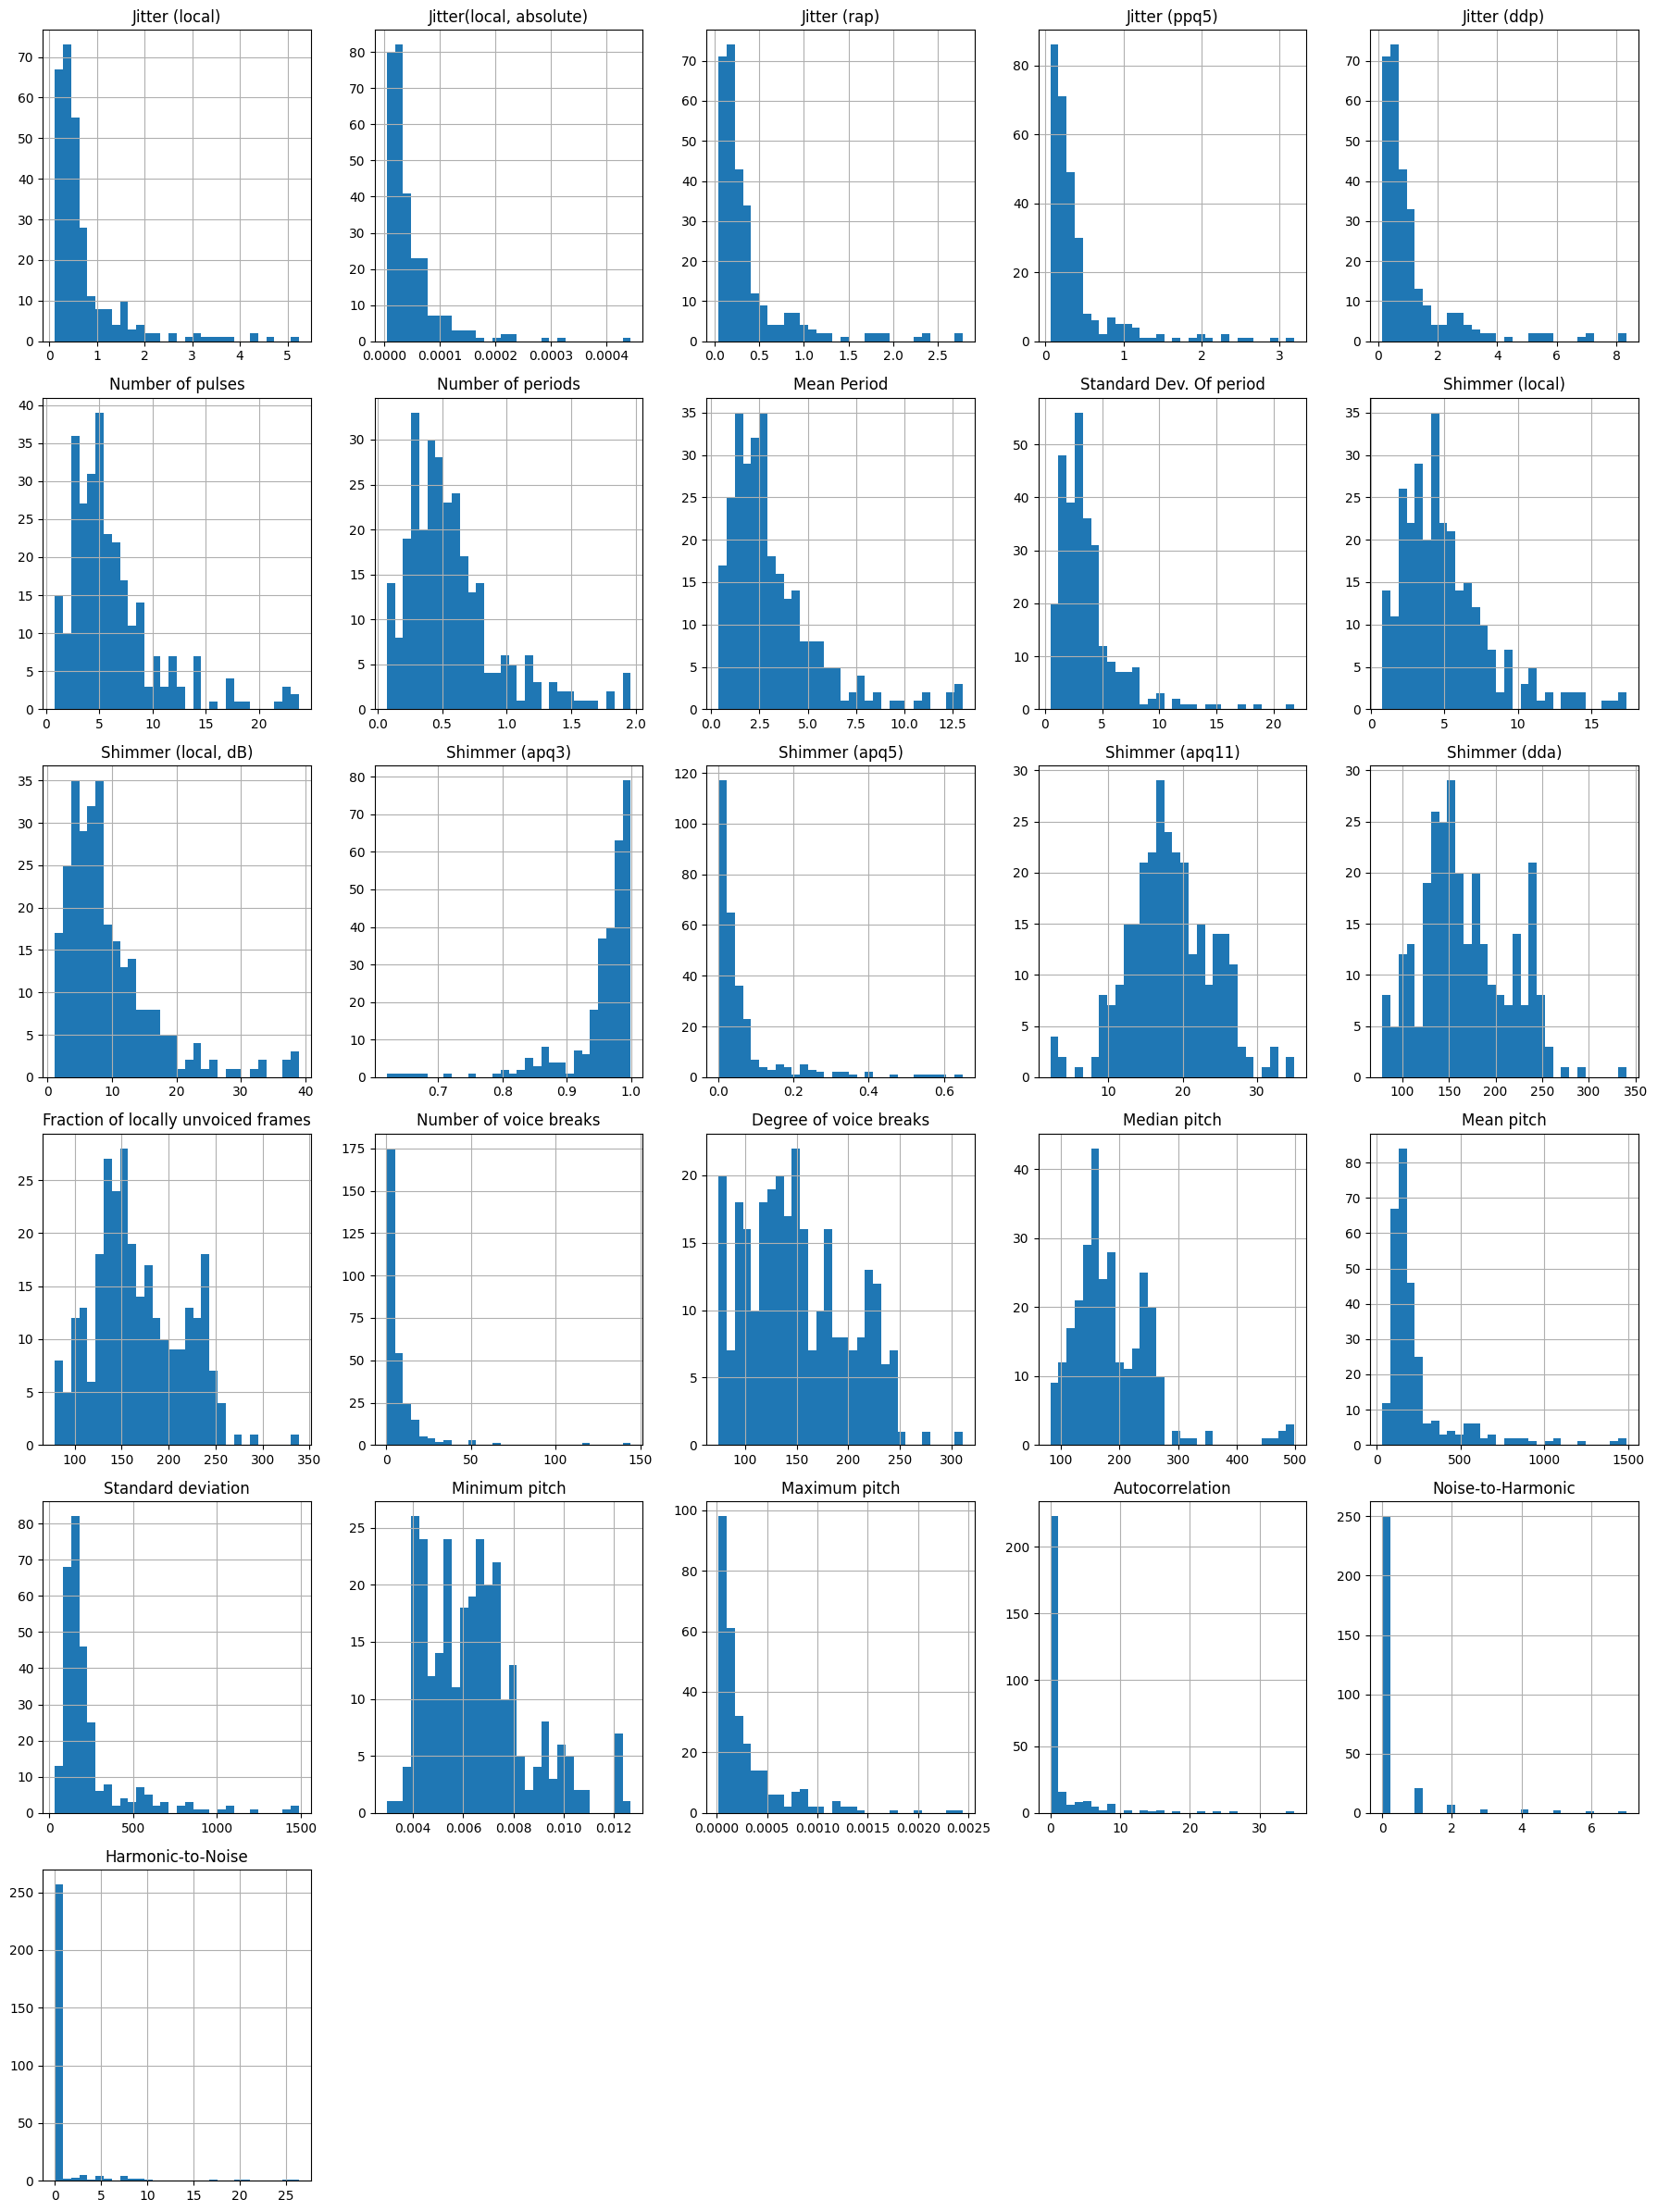

In [ ]:
import matplotlib.pyplot as plt

# Histograms
selected_columns =  [
    'Jitter (local)', 'Jitter(local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)', 'Jitter (ddp)', 'Number of pulses',
    'Number of periods', 'Mean Period', 'Standard Dev. Of period', 'Shimmer (local)', 'Shimmer (local, dB)',
    'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)', 'Fraction of locally unvoiced frames',
    'Number of voice breaks', 'Degree of voice breaks', 'Median pitch', 'Mean pitch', 'Standard deviation',
    'Minimum pitch', 'Maximum pitch', 'Autocorrelation', 'Noise-to-Harmonic', 'Harmonic-to-Noise'
]

num_features = len(selected_columns)
num_cols = 5
num_rows = int(np.ceil(num_features / num_cols))

plt.figure(figsize=(18, num_rows * 4))

for i, column in enumerate(selected_columns, 1):
    plt.subplot(num_rows, num_cols, i)
    df[column].hist(bins=30)
    plt.title(column)
    plt.tight_layout()


plt.savefig("/content/drive/MyDrive/UCI Feature Histogram.png")
plt.show()

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Function to filter and scale the DataFrame
def filter_and_scale_df(df):
    # Apply filtering criteria for each column
    # df = df[df['Jitter (local)'] <= 0.01]
    df = df[df['Jitter(local, absolute)'] <= 0.0004]
    df = df[df['Jitter (rap)'] <= 2]
    # df = df[df['Jitter (ppq5)'] <= 0.01]
    df = df[df['Jitter (ddp)'] <= 6]
    df = df[df['Number of pulses'] <= 20]
    # df = df[df['Number of periods'] <= 500]
    # df = df[df['Mean Period'] <= 0.01]
    df = df[df['Standard Dev. Of period'] <= 20]
    df = df[df['Shimmer (local)'] <= 15]
    # df = df[df['Shimmer (local, dB)'] <= 0.5]
    df = df[df['Shimmer (apq3)'] >= 0.76]
    # df = df[df['Shimmer (apq5)'] <= 0.05]
    # df = df[df['Shimmer (apq11)'] <= 0.05]
    df = df[df['Shimmer (dda)'] <= 300]
    df = df[df['Fraction of locally unvoiced frames'] <= 300]
    df = df[df['Number of voice breaks'] <= 50]
    df = df[df['Degree of voice breaks'] <= 250]
    df = df[df['Median pitch'] <= 400]
    df = df[df['Mean pitch'] <= 1000]
    df = df[df['Standard deviation'] <= 1000]
    df = df[df['Minimum pitch'] <= 0.012]
    df = df[df['Maximum pitch'] <= 0.0015]
    df = df[df['Autocorrelation'] <= 20]
    # df = df[df['Noise-to-Harmonic'] <= 0.5]
    # df = df[df['Harmonic-to-Noise'] <= 0.5]

    # Keep only the necessary features
    selected_columns =  [
        'Jitter (local)', 'Jitter(local, absolute)', 'Jitter (rap)', 'Jitter (ppq5)', 'Jitter (ddp)', 'Number of pulses',
        'Number of periods', 'Mean Period', 'Standard Dev. Of period', 'Shimmer (local)', 'Shimmer (local, dB)',
        'Shimmer (apq3)', 'Shimmer (apq5)', 'Shimmer (apq11)', 'Shimmer (dda)', 'Fraction of locally unvoiced frames',
        'Number of voice breaks', 'Degree of voice breaks', 'Median pitch', 'Mean pitch', 'Standard deviation',
        'Minimum pitch', 'Maximum pitch', 'Autocorrelation', 'Noise-to-Harmonic', 'Harmonic-to-Noise'
    ]

    features = df[selected_columns].values
    labels = df['status'].values

    # Scale the features to between -1 and 1
    scaler = MinMaxScaler((-1, 1))
    scaled_features = scaler.fit_transform(features)

    return df, scaled_features, labels


# Preprocess Kaggle data
df, x, y = filter_and_scale_df(df)

In [ ]:
df.shape, x.shape

((251, 28), (251, 26))

In [ ]:
df.iloc[:, 1:-1].skew()

Jitter (local)                         2.683809
Jitter(local, absolute)                2.745141
Jitter (rap)                           2.542664
Jitter (ppq5)                          3.242902
Jitter (ddp)                           2.543131
Number of pulses                       1.355037
Number of periods                      1.222604
Mean Period                            1.547377
Standard Dev. Of period                1.509293
Shimmer (local)                        0.989193
Shimmer (local, dB)                    1.547314
Shimmer (apq3)                        -2.078194
Shimmer (apq5)                         2.812815
Shimmer (apq11)                        0.411735
Shimmer (dda)                          0.350664
Fraction of locally unvoiced frames    0.358964
Number of voice breaks                 3.047485
Degree of voice breaks                 0.346903
Median pitch                           0.491832
Mean pitch                             2.405663
Standard deviation                     2

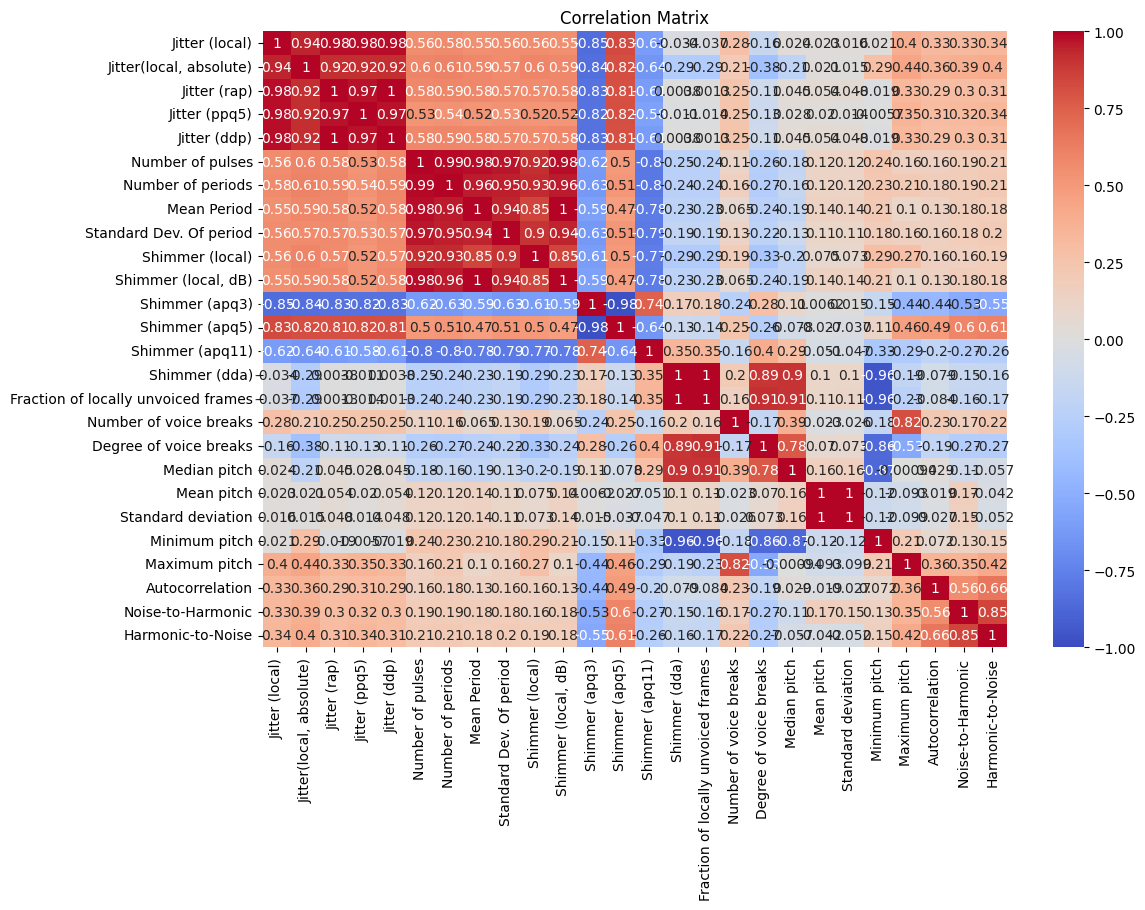

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = df.iloc[:, 1:-1].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.savefig("/content/drive/MyDrive/UCI Correlation Matrix Bef.png")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate VIF for each feature in the dataframe
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

# Assuming df is your original dataframe with all features
# Drop the first column if it's not a feature column
df_features = df.iloc[:, 1:]

# Calculate VIF for the features
vif_df = calculate_vif(df_features)

# Sort the VIF values in descending order
vif_df_sorted = vif_df.sort_values(by="VIF", ascending=False)

# Print the VIF values for all features
print("VIF values for all features:")
print(vif_df_sorted)

VIF values for all features:
                                feature           VIF
10                  Shimmer (local, dB)  1.777370e+08
7                           Mean Period  1.777280e+08
2                          Jitter (rap)  3.659673e+06
4                          Jitter (ddp)  3.656193e+06
19                           Mean pitch  8.053611e+04
20                   Standard deviation  7.985693e+04
15  Fraction of locally unvoiced frames  1.041158e+04
14                        Shimmer (dda)  7.858210e+03
11                       Shimmer (apq3)  9.467789e+02
5                      Number of pulses  7.241642e+02
17               Degree of voice breaks  3.473019e+02
6                     Number of periods  2.944513e+02
21                        Minimum pitch  2.630016e+02
0                        Jitter (local)  2.547964e+02
18                         Median pitch  2.306518e+02
1               Jitter(local, absolute)  8.719330e+01
8               Standard Dev. Of period  8.409156e+01

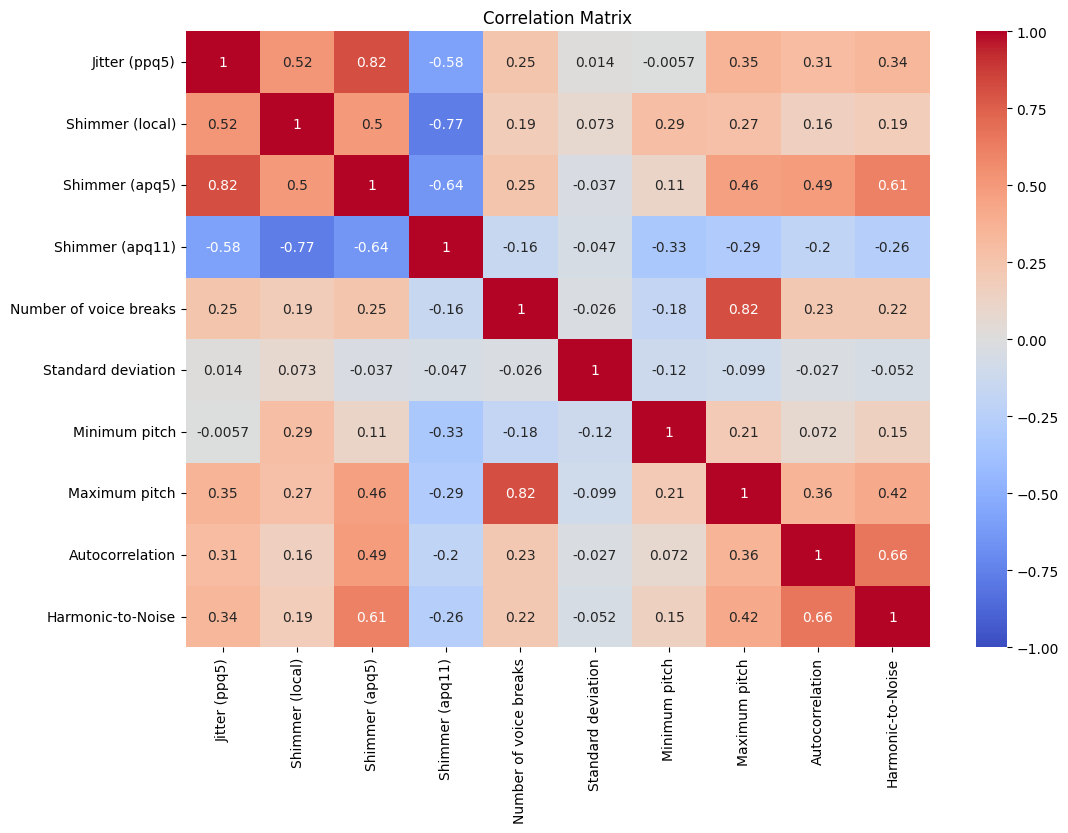

In [ ]:
# Correlation matrix
selected_columns =  [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ]
plt.figure(figsize=(12, 8))
correlation_matrix = df[selected_columns].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')

plt.savefig("/content/drive/MyDrive/UCI Correlation Matrix Aft.png")
plt.show()

In [ ]:
# Function to filter and scale the DataFrame
def feature_select_df(df):

    # Keep only the necessary features
    selected_columns =  [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ]

    features = df[selected_columns].values
    labels = df['status'].values

    # Scale the features to between -1 and 1
    scaler = MinMaxScaler((-1, 1))
    scaled_features = scaler.fit_transform(features)

    return df, scaled_features, labels

# Preprocess Kaggle data
df, x, y = feature_select_df(df)

In [ ]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Split the Kaggle data into training and testing sets
# xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.5, random_state=42)
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


# Combine features, labels, and names into a single DataFrame
df_combined = df[['name']].copy()
df_combined[selected_columns] = x
df_combined['status'] = y

# Group by 'name'
grouped = df_combined.groupby('name')

# Convert groups to a list and shuffle with a fixed random state
groups = list(grouped)
random_state = 42
np.random.seed(random_state)  # Set the seed for reproducibility
np.random.shuffle(groups)

# Split groups into training and testing sets
train_groups = []
test_groups = []
train_size = 0
test_size = 0

# Iterate through the shuffled groups and assign them to train or test set
for group_name, group_data in groups:
    if train_size <= test_size:
        train_groups.append(group_data)
        train_size += len(group_data)
    else:
        test_groups.append(group_data)
        test_size += len(group_data)

# Concatenate the groups back into DataFrames
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Separate features and labels
xtrain = train_df[selected_columns].values
xtest = test_df[selected_columns].values
ytrain = train_df['status'].values
ytest = test_df['status'].values

# Print the shapes to verify the splits
print("xtrain shape:", xtrain.shape)
print("xtest shape:", xtest.shape)
print("ytrain shape:", ytrain.shape)
print("ytest shape:", ytest.shape)


xtrain shape: (126, 10)
xtest shape: (125, 10)
ytrain shape: (126,)
ytest shape: (125,)


In [ ]:
# Generate summary of who is included in xtrain and how many data points each has
train_summary = train_df['name'].value_counts().reset_index()
train_summary.columns = ['name', 'num_samples']

# Print the summary
print("Summary of individuals in xtrain:")
print(train_summary)

Summary of individuals in xtrain:
    name  num_samples
0     27            9
1      9            9
2     20            9
3     23            9
4     21            9
5      6            9
6      2            9
7     15            8
8     24            8
9      1            8
10     3            8
11    28            7
12    14            7
13    16            6
14    35            3
15    36            3
16    37            2
17    40            2
18    34            1


In [ ]:
# Generate summary of who is included in xtrain and how many data points each has
test_summary = test_df['name'].value_counts().reset_index()
test_summary.columns = ['name', 'num_samples']

# Print the summary
print("Summary of individuals in xtrain:")
print(test_summary)

Summary of individuals in xtrain:
    name  num_samples
0      7            9
1     12            9
2     10            9
3     25            9
4     11            9
5     19            9
6     22            9
7      4            8
8      8            8
9     26            8
10     5            7
11    18            7
12    13            6
13    17            4
14    39            3
15    30            3
16    29            3
17    38            2
18    33            2
19    31            1


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Function to inject noise into the data
def inject_noise(data, noise_level=0.01):
    noisy_data = data + noise_level * np.random.normal(size=data.shape)
    return noisy_data

# Apply SMOTE to generate synthetic data
smote = SMOTE(random_state=42)
xtrain_smote, ytrain_smote = smote.fit_resample(xtrain, ytrain)

# Initialize lists to store augmented data
augmented_data_list = [xtrain_smote]
augmented_labels_list = [ytrain_smote]

# Repeat augmentation process four times
for _ in range(4):
    # Inject noise into the SMOTE-generated data
    xtrain_smote_noisy = inject_noise(xtrain_smote)

    # Append the augmented data to the lists
    augmented_data_list.append(xtrain_smote_noisy)
    augmented_labels_list.append(ytrain_smote)

# Combine all augmented data and labels
augmented_data_combined = pd.DataFrame(np.vstack(augmented_data_list), columns= [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ])
augmented_labels_combined = pd.Series(np.hstack(augmented_labels_list), name='status')

# Concatenate the augmented data and labels into a single DataFrame
augmented_df_combined = pd.concat([augmented_data_combined, augmented_labels_combined], axis=1)

In [ ]:
augmented_df_combined.shape

(1020, 11)

In [ ]:
augmented_labels_combined.value_counts()

status
0    510
1    510
Name: count, dtype: int64

In [ ]:
from sklearn.linear_model import LogisticRegression

# Define the logistic regression model
model1 = LogisticRegression()
model1.fit(augmented_data_combined , augmented_labels_combined )

LogisticRegression()

Training Accuracy: 76.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.77      0.53        22
           1       0.94      0.76      0.84       103

    accuracy                           0.76       125
   macro avg       0.67      0.77      0.68       125
weighted avg       0.85      0.76      0.78       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

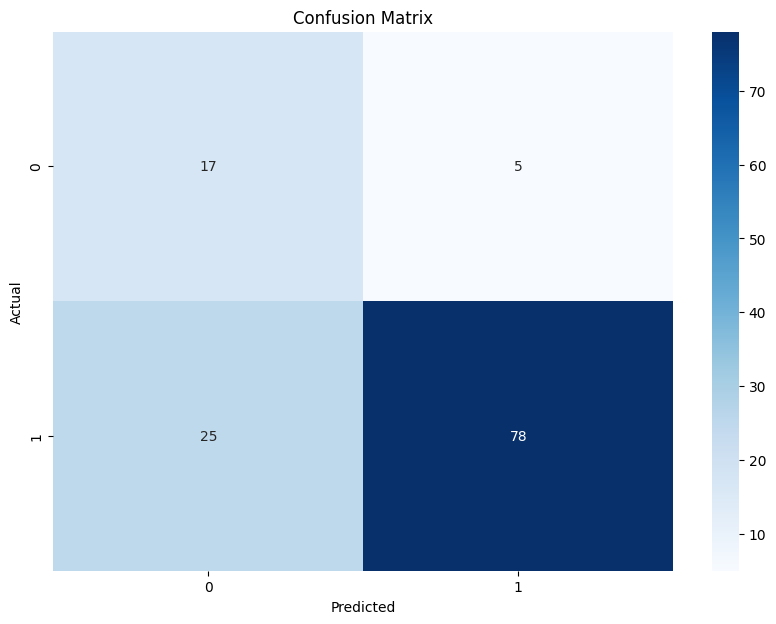

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model1.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


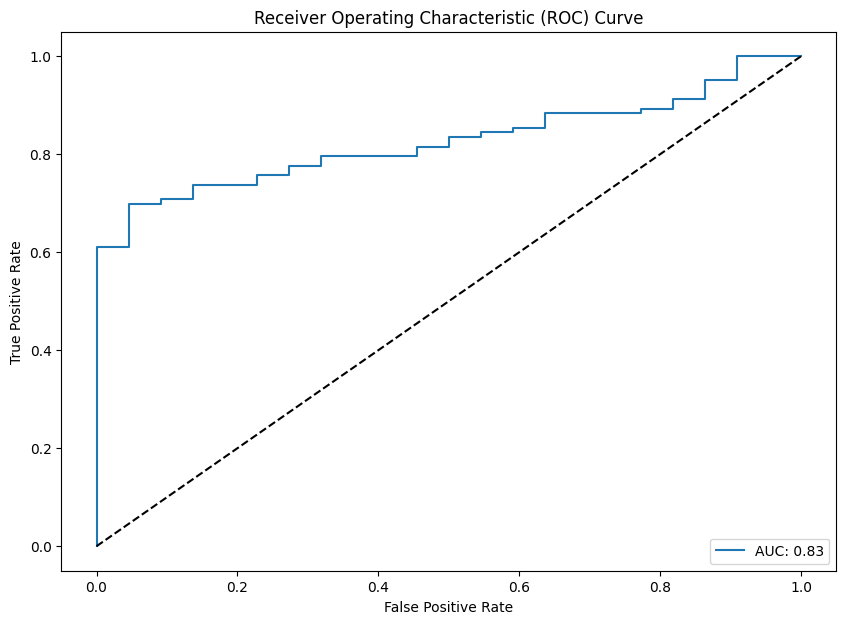

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model1.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
import joblib

# Save the model using joblib
joblib.dump(model1, '/content/drive/MyDrive/UCI Logisitic Regression.joblib')

['/content/drive/MyDrive/UCI Logisitic Regression.joblib']

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Define the logistic regression model
model2 = KNeighborsClassifier(n_neighbors = 7)
model2.fit(augmented_data_combined, augmented_labels_combined)

KNeighborsClassifier(n_neighbors=7)

Training Accuracy: 62.40%
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.36      0.25        22
           1       0.83      0.68      0.75       103

    accuracy                           0.62       125
   macro avg       0.51      0.52      0.50       125
weighted avg       0.72      0.62      0.66       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

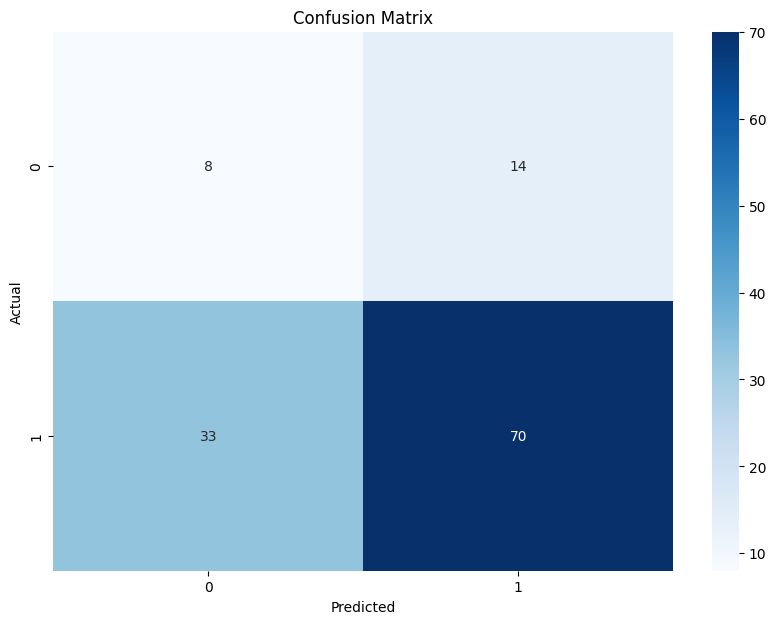

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model2.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.48


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


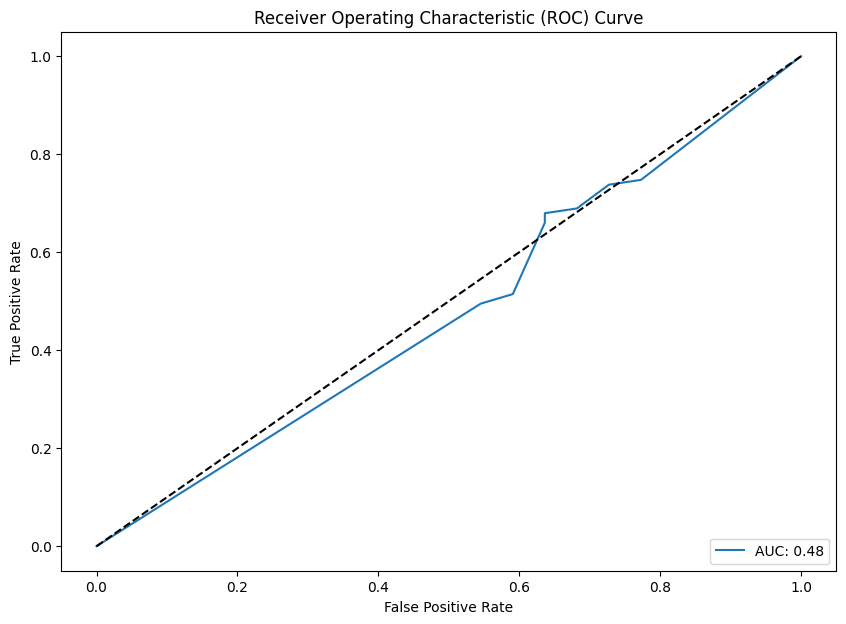

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model2.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.tree import DecisionTreeClassifier

model3 = DecisionTreeClassifier(max_depth = 4,min_samples_split = 2,max_leaf_nodes = 2)
model3.fit(augmented_data_combined, augmented_labels_combined)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=2)

Training Accuracy: 76.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.68      0.50        22
           1       0.92      0.78      0.84       103

    accuracy                           0.76       125
   macro avg       0.66      0.73      0.67       125
weighted avg       0.83      0.76      0.78       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

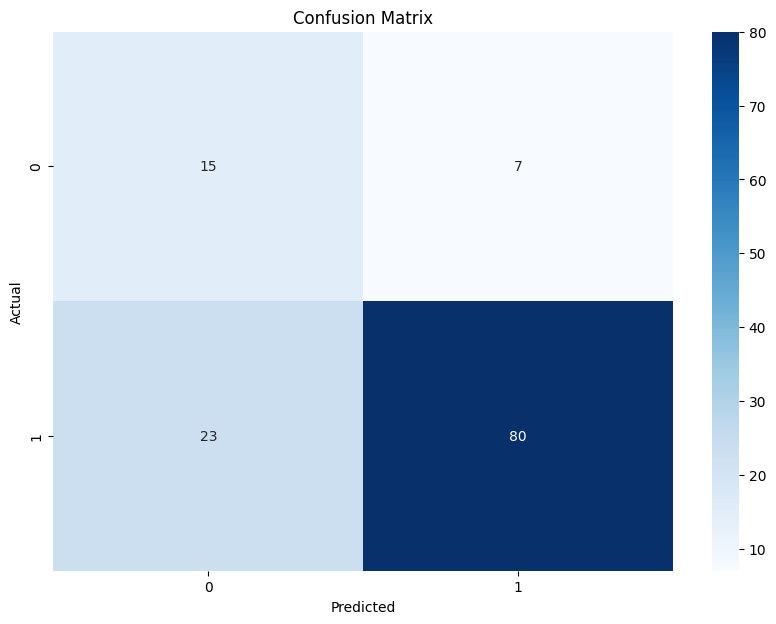

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model3.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.73


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


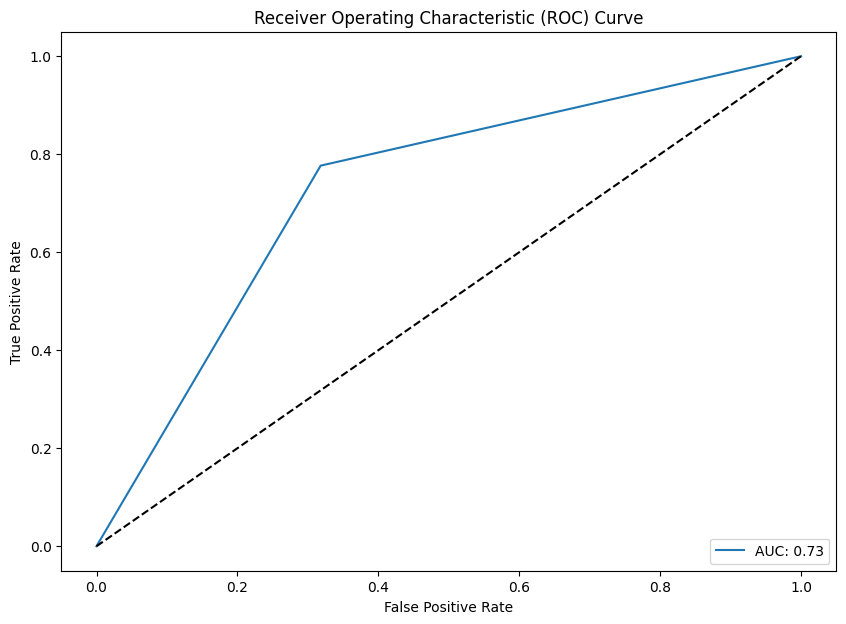

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model3.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.ensemble import RandomForestClassifier

model4 = RandomForestClassifier(max_depth = 5,n_estimators = 1000,criterion = 'gini')
model4.fit(augmented_data_combined, augmented_labels_combined)

RandomForestClassifier(max_depth=5, n_estimators=1000)

Training Accuracy: 71.20%
Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.50      0.38        22
           1       0.88      0.76      0.81       103

    accuracy                           0.71       125
   macro avg       0.59      0.63      0.60       125
weighted avg       0.78      0.71      0.74       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

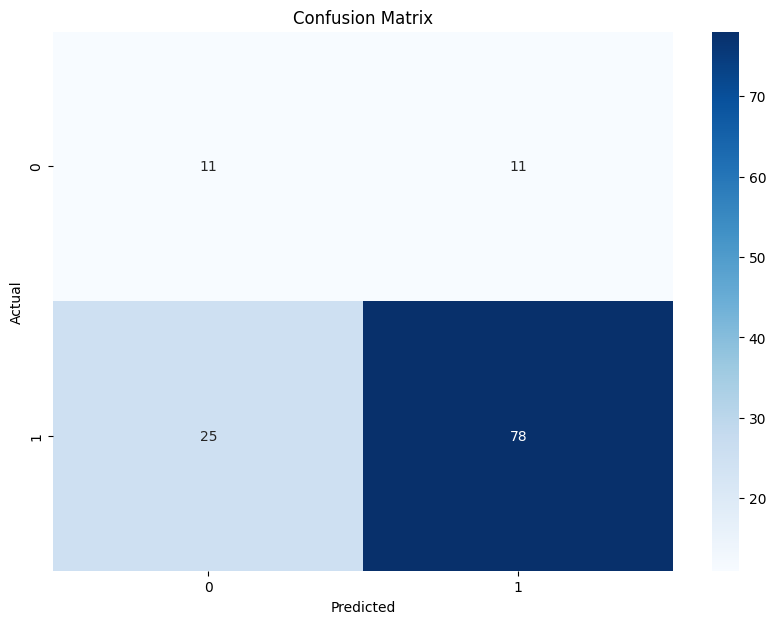

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model4.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.74


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


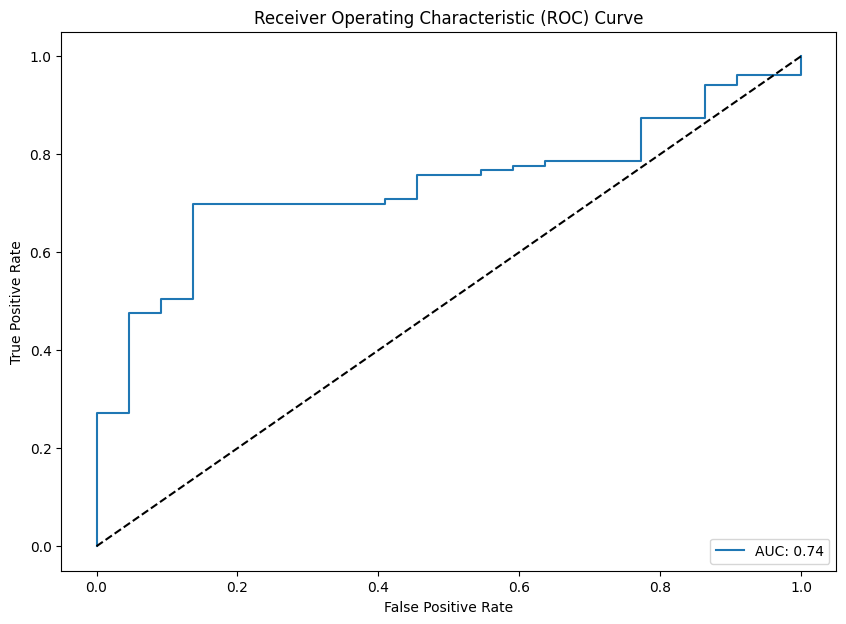

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model4.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# Define the logistic regression model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

model5 = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 4,min_samples_split = 2,max_leaf_nodes = 2),n_estimators = 93)
model5.fit(augmented_data_combined, augmented_labels_combined)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=4,
                                                    max_leaf_nodes=2),
                   n_estimators=93)

Training Accuracy: 64.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.41      0.29        22
           1       0.85      0.69      0.76       103

    accuracy                           0.64       125
   macro avg       0.53      0.55      0.52       125
weighted avg       0.74      0.64      0.68       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

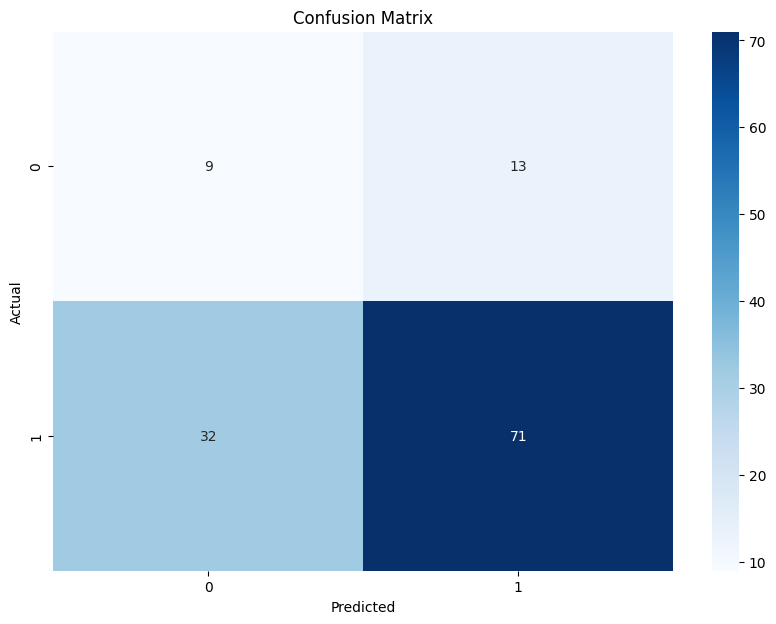

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model5.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.54


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


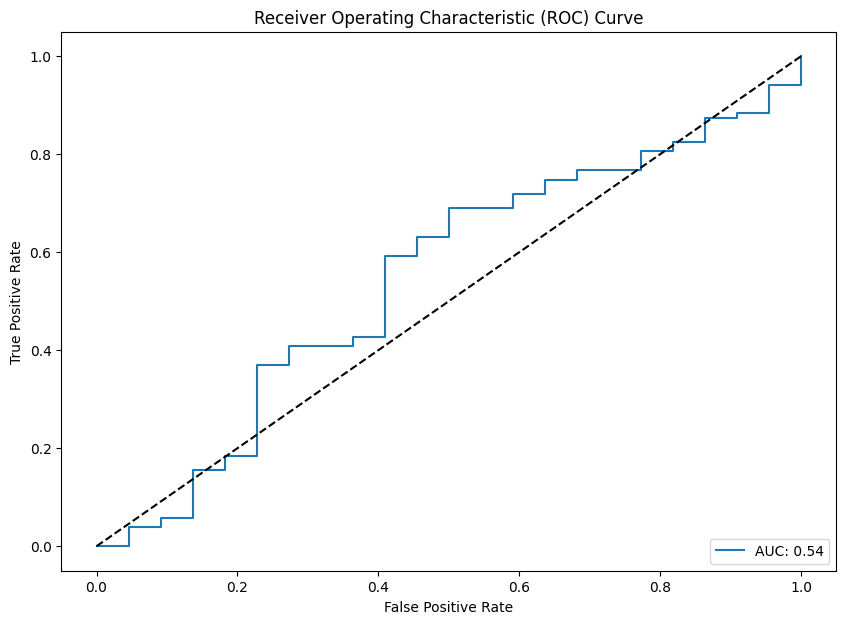

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model5.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import accuracy_score, log_loss
import math

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

sigmoid = np.vectorize(sigmoid)

# Initialize StratifiedKFold with 10 splits
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Arrays to store cross-validation scores and losses
cv_score = []
cv_loss = []

# Perform Stratified K-Fold cross-validation for different numbers of PLS components
for i in range(1, 16):
    scores = []
    losses = []
    for train_index, test_index in skf.split(augmented_data_combined, augmented_labels_combined):
        # Ensure the number of components does not exceed the rank upper bound
        n_components = min(i, augmented_data_combined[train_index].shape[0], augmented_data_combined[train_index].shape[1])
        lm = PLSRegression(n_components=n_components)
        lm.fit(augmented_data_combined[train_index],augmented_labels_combined[train_index])
        y_pred_pls = lm.predict(augmented_data_combined[test_index])
        y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
        scores.append(accuracy_score(y_pred, augmented_labels_combined[test_index]))
        losses.append(log_loss(augmented_labels_combined[test_index], sigmoid(y_pred_pls)))
    cv_score.append(np.mean(scores))
    cv_loss.append(np.mean(losses))

# Print the cross-validation results
print("Cross-Validation Accuracy Scores for different PLS components:", cv_score)
print("Cross-Validation Log Loss for different PLS components:", cv_loss)

KeyError: "None of [Index([   0,    1,    2,    3,    4,    5,    7,    8,    9,   10,\n       ...\n       1009, 1010, 1011, 1013, 1014, 1015, 1016, 1017, 1018, 1019],\n      dtype='int64', length=918)] are in the [columns]"

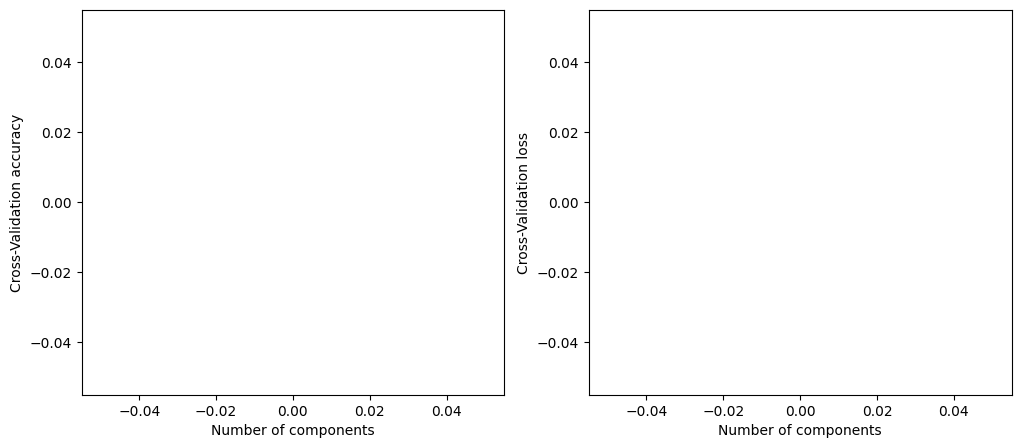

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(cv_score)
ax[1].plot(cv_loss)
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Cross-Validation accuracy')
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Cross-Validation loss');

In [ ]:
model6 = PLSRegression(n_components=4)
model6.fit(augmented_data_combined, augmented_labels_combined)
y_pred_pls = model6.predict(xtest)
y_pred = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
accuracy_score(y_pred, ytest)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


0.768

Training Accuracy: 76.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.54        22
           1       0.94      0.77      0.84       103

    accuracy                           0.77       125
   macro avg       0.68      0.77      0.69       125
weighted avg       0.85      0.77      0.79       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

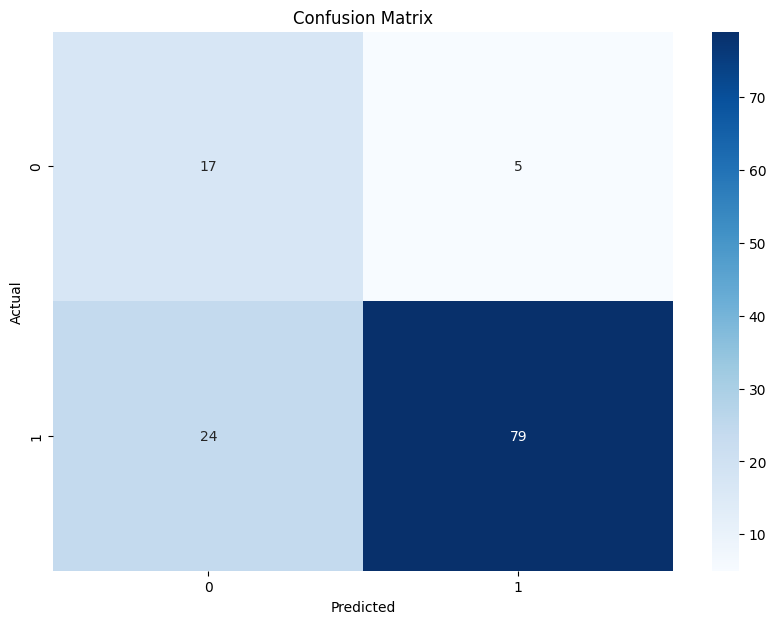

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
y_pred_pls = model6.predict(xtest)
predict = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.85


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


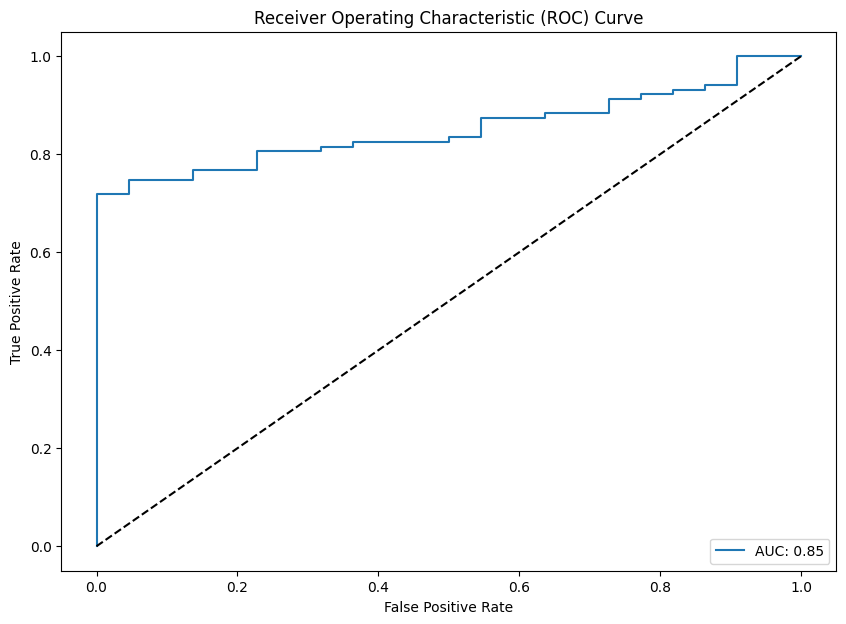

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model6.predict(xtest) # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
from sklearn.svm import SVC
model7 = SVC(kernel='linear', probability =True)
model7.fit(augmented_data_combined, augmented_labels_combined)

SVC(kernel='linear', probability=True)

Training Accuracy: 72.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.35      0.64      0.45        22
           1       0.91      0.75      0.82       103

    accuracy                           0.73       125
   macro avg       0.63      0.69      0.64       125
weighted avg       0.81      0.73      0.75       125



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Confusion Matrix')

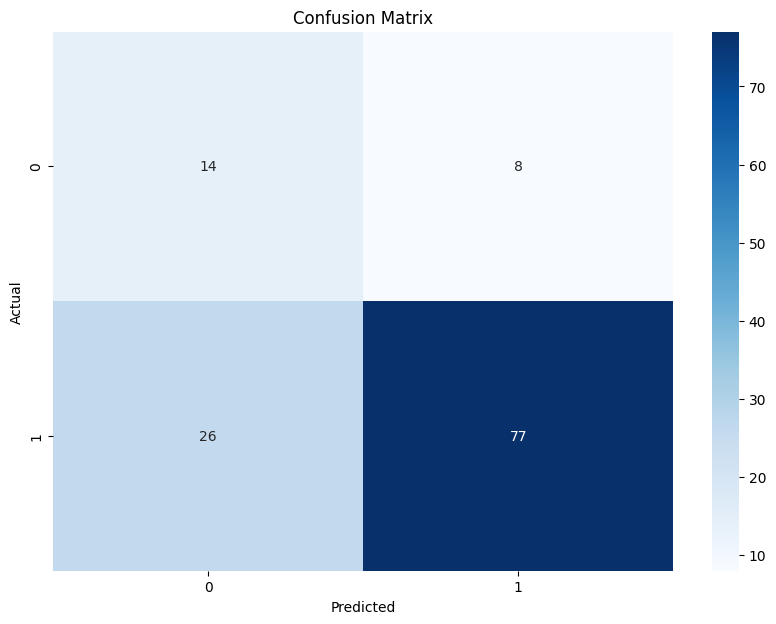

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model7.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

AUC: 0.83


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


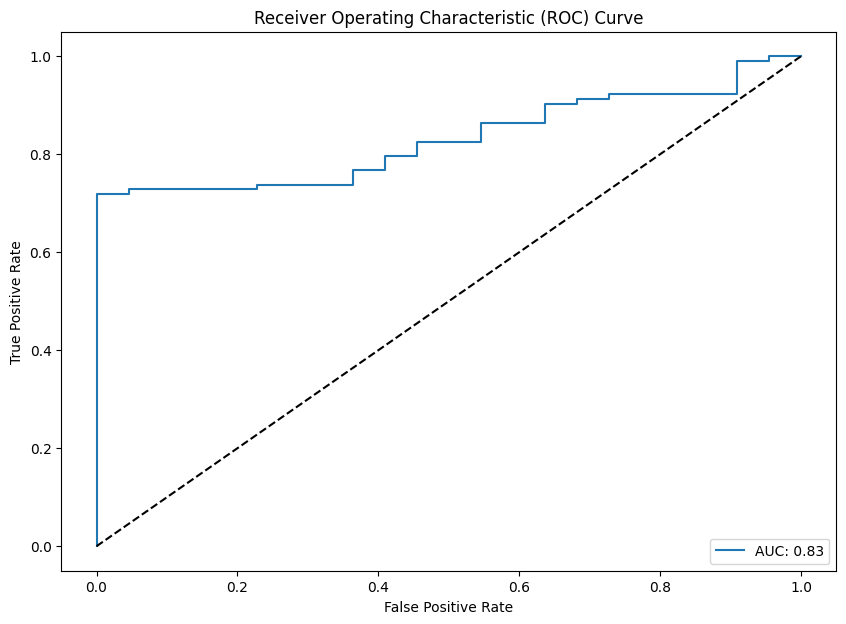

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model7.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

In [ ]:
# import joblib

# Save the model using joblib
joblib.dump(model7, '/content/drive/MyDrive/UIC SVC.joblib')

['/content/drive/MyDrive/UIC SVC.joblib']

In [ ]:
# Train the model
model8 = XGBClassifier()
model8.fit(augmented_data_combined, augmented_labels_combined)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

Training Accuracy: 69.60%
Classification Report:
              precision    recall  f1-score   support

           0       0.19      0.23      0.21        22
           1       0.83      0.80      0.81       103

    accuracy                           0.70       125
   macro avg       0.51      0.51      0.51       125
weighted avg       0.72      0.70      0.71       125



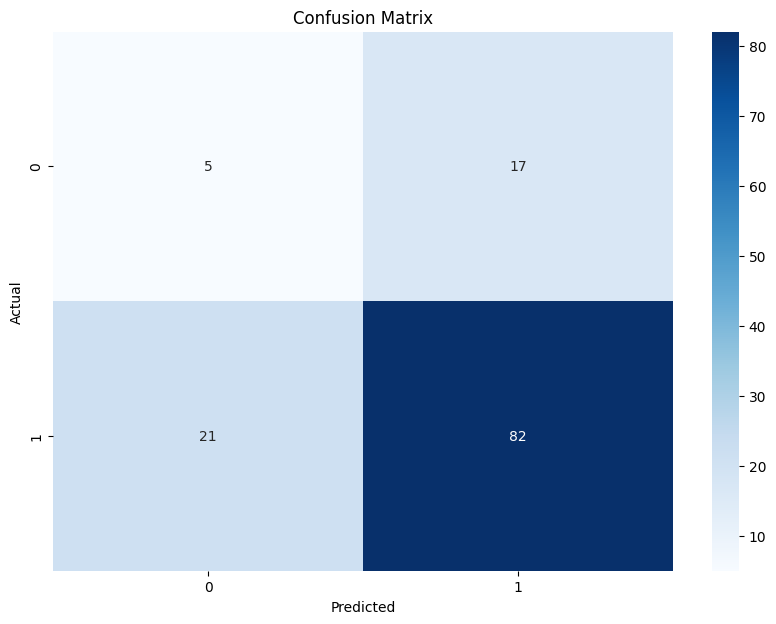

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
predict = model8.predict(xtest)
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("/content/drive/MyDrive/UCI Result.png")
plt.show()

AUC: 0.65


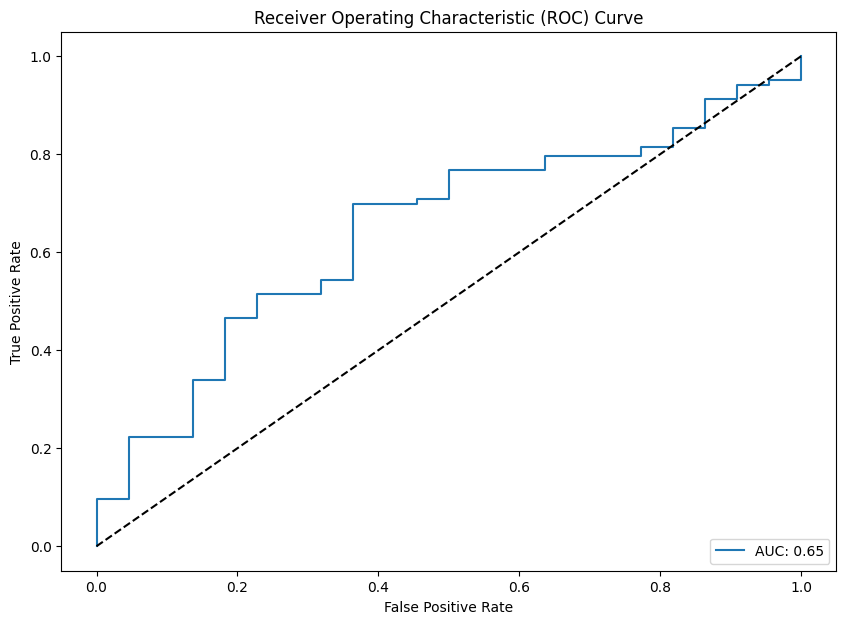

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model8.predict_proba(xtest)[:, 1]  # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig("/content/drive/MyDrive/UCI ROC Curve.png")
plt.show()

In [ ]:
import joblib

# Save the model using joblib
model = model6
model_save_path = '/content/drive/MyDrive/UCI model.joblib'
joblib.dump(model, model_save_path)

['/content/drive/MyDrive/UCI model.joblib']

In [ ]:
# Load the model using joblib
model_save_path = '/content/drive/MyDrive/UCI model.joblib'
model = joblib.load(model_save_path)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


Training Accuracy: 76.80%
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.54        22
           1       0.94      0.77      0.84       103

    accuracy                           0.77       125
   macro avg       0.68      0.77      0.69       125
weighted avg       0.85      0.77      0.79       125



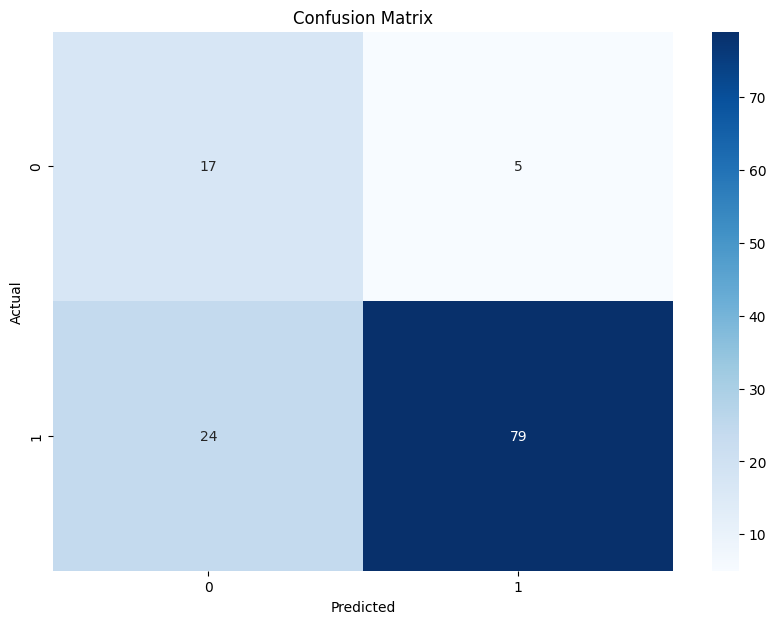

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the Kaggle test set
y_pred_pls = model.predict(xtest)
predict = np.array([1 if y > 0.5 else 0 for y in y_pred_pls])
print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")
# Evaluate the model on the test set
# predict = best_model.predict(xtest)
# print(f"Training Accuracy: {accuracy_score(ytest, predict) * 100:.2f}%")

# Additional Evaluation Metrics
print("Classification Report:")
print(classification_report(ytest, predict))

# Confusion Matrix
conf_matrix = confusion_matrix(ytest, predict)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')

plt.savefig("/content/drive/MyDrive/UCI Result.png")
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PLSRegression was fitted with feature names
  warnings.warn(


AUC: 0.85


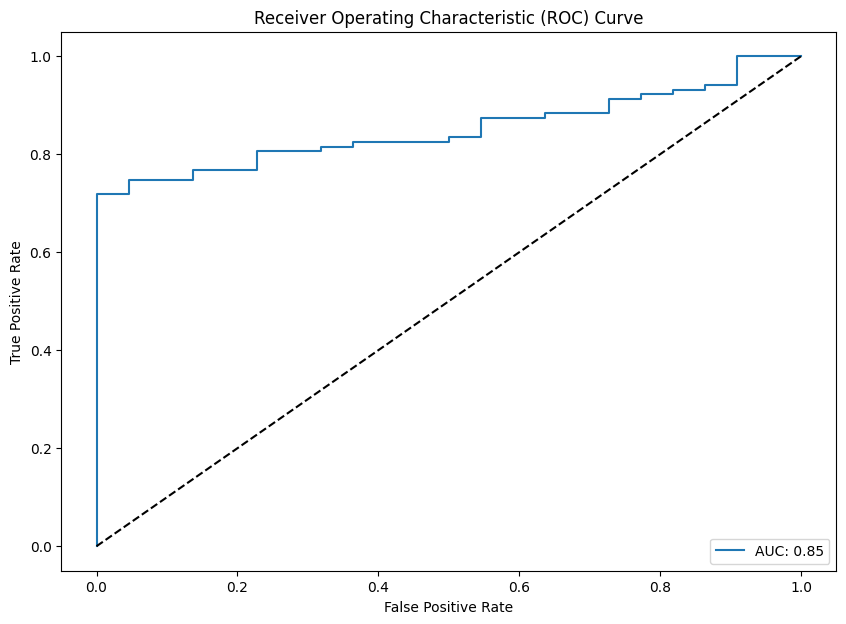

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt

# AUROC and AUC
# Evaluate the model on the Kaggle test set
predict_proba = model.predict(xtest) # Get the probabilities of the positive class

auc = roc_auc_score(ytest, predict_proba)
print(f"AUC: {auc:.2f}")

fpr, tpr, _ = roc_curve(ytest, predict_proba)
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, label=f'AUC: {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

plt.savefig("/content/drive/MyDrive/UCI ROC Curve.png")
plt.show()

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 34.9 MB/s eta 0:00:00


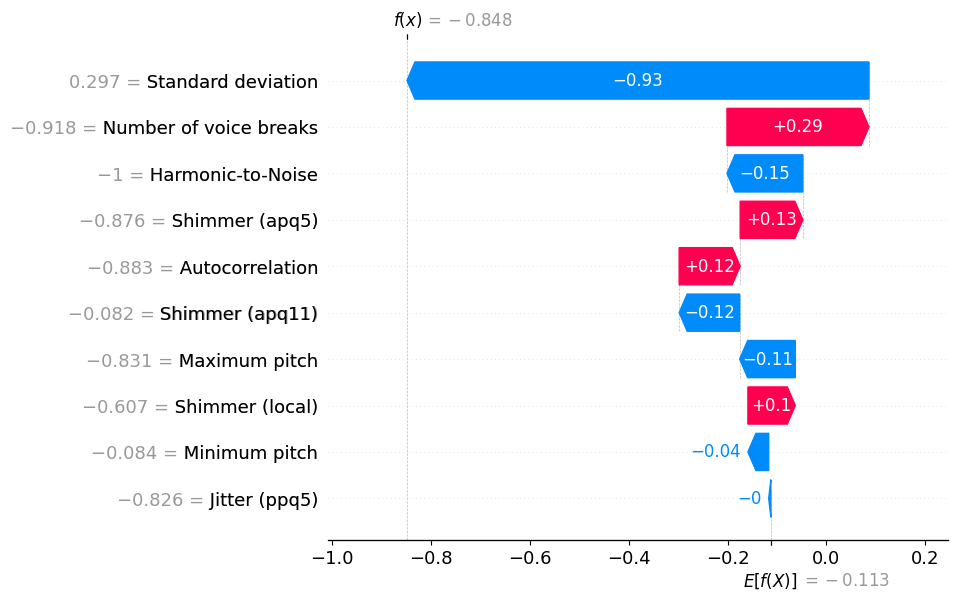

In [ ]:
import shap
import matplotlib.pyplot as plt

# Ensure that the model and training data (xtrain) are defined
selected_columns = [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ]

# Create a SHAP explainer
explainer = shap.Explainer(model1, augmented_data_combined, feature_names= selected_columns)  # assuming 'status' is the last column

# Calculate SHAP values
shap_values = explainer(xtest)

# Plot summary plot
# shap.summary_plot(shap_values, xtest, feature_names=selected_columns, plot_type="bar")

# Plot detailed SHAP values for a single prediction
shap.initjs()

shap.plots.waterfall(shap_values[0])
# shap.force_plot(shap_values[0])
# shap.force_plot(explainer.expected_value, shap_values[0,:], xtest[0], feature_names=selected_columns)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Extract the features
selected_columns =  [
        'Jitter (local)','Number of pulses',
        'Shimmer (apq3)',
        'Fraction of locally unvoiced frames',
        'Number of voice breaks', 'Standard deviation',
        'Maximum pitch', 'Autocorrelation', 'Noise-to-Harmonic', 'Harmonic-to-Noise'
    ]

features = df[selected_columns].values

# Standardize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

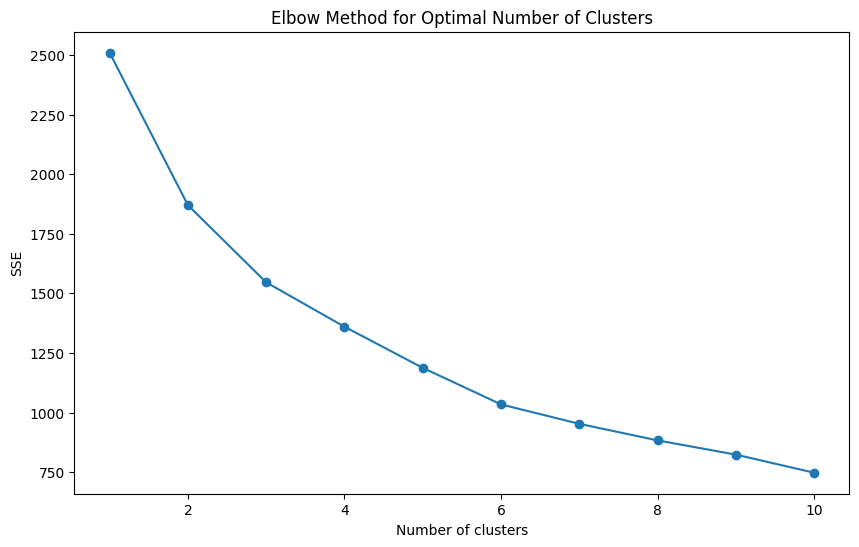

In [ ]:
# Elbow method to find the optimal number of clusters
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()


In [ ]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(features_scaled)

# Add cluster labels to the original dataframe
df['kmeans_cluster'] = kmeans_labels

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


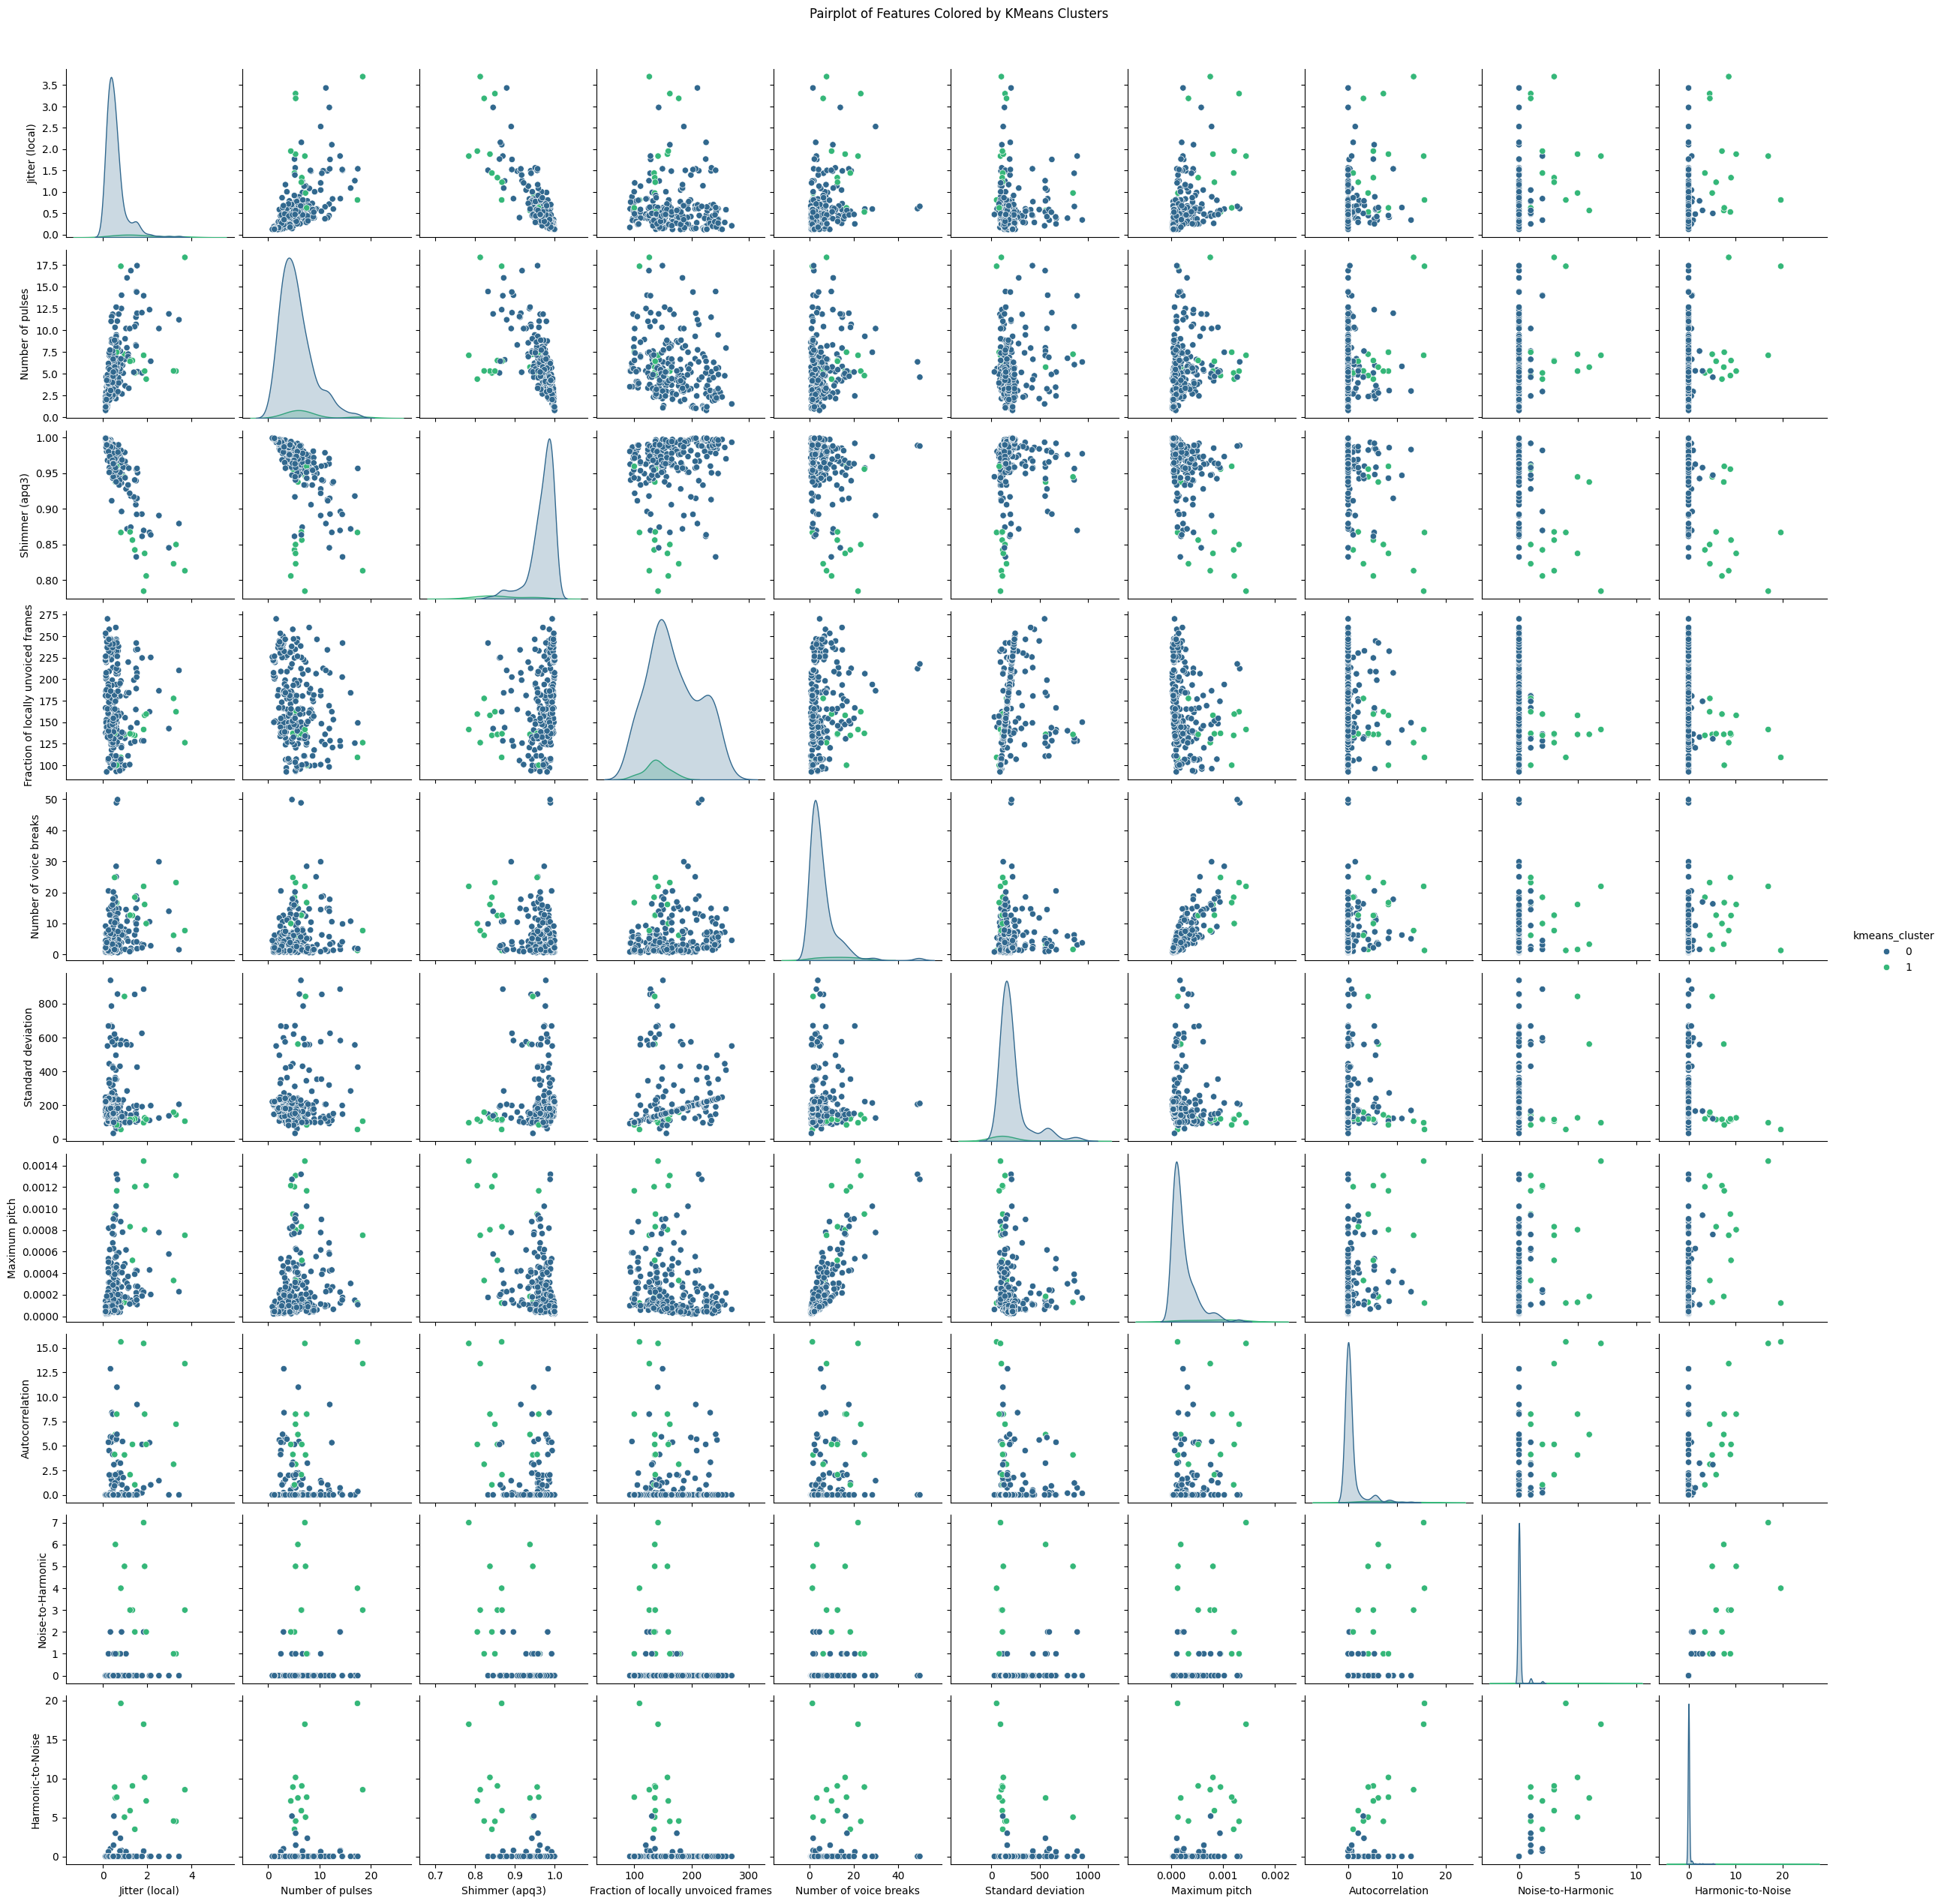

In [ ]:
# Draw the pairplot
selected_columns =  [
        'Jitter (local)','Number of pulses',
        'Shimmer (apq3)',
        'Fraction of locally unvoiced frames',
        'Number of voice breaks', 'Standard deviation',
        'Maximum pitch', 'Autocorrelation', 'Noise-to-Harmonic', 'Harmonic-to-Noise'
    ]

sns.pairplot(df, hue='kmeans_cluster', vars=selected_columns, palette='viridis')
plt.suptitle('Pairplot of Features Colored by KMeans Clusters', y=1.02)
plt.show()

Cohen's d values for each feature:
Jitter (ppq5): -0.10
Shimmer (local): 0.14
Shimmer (apq5): 0.06
Shimmer (apq11): -0.15
Number of voice breaks: 0.40
Standard deviation: 0.62
Minimum pitch: -0.01
Maximum pitch: 0.20
Autocorrelation: 0.54
Harmonic-to-Noise: 0.08


<ipython-input-77-952d70cb3b9d>:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
<ipython-input-77-952d70cb3b9d>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 1][feature], shade=True, label='status = 1', color='orange')
<ipython-input-77-952d70cb3b9d>:32: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
<ipython-input-77-952d70cb3b9d>:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error 

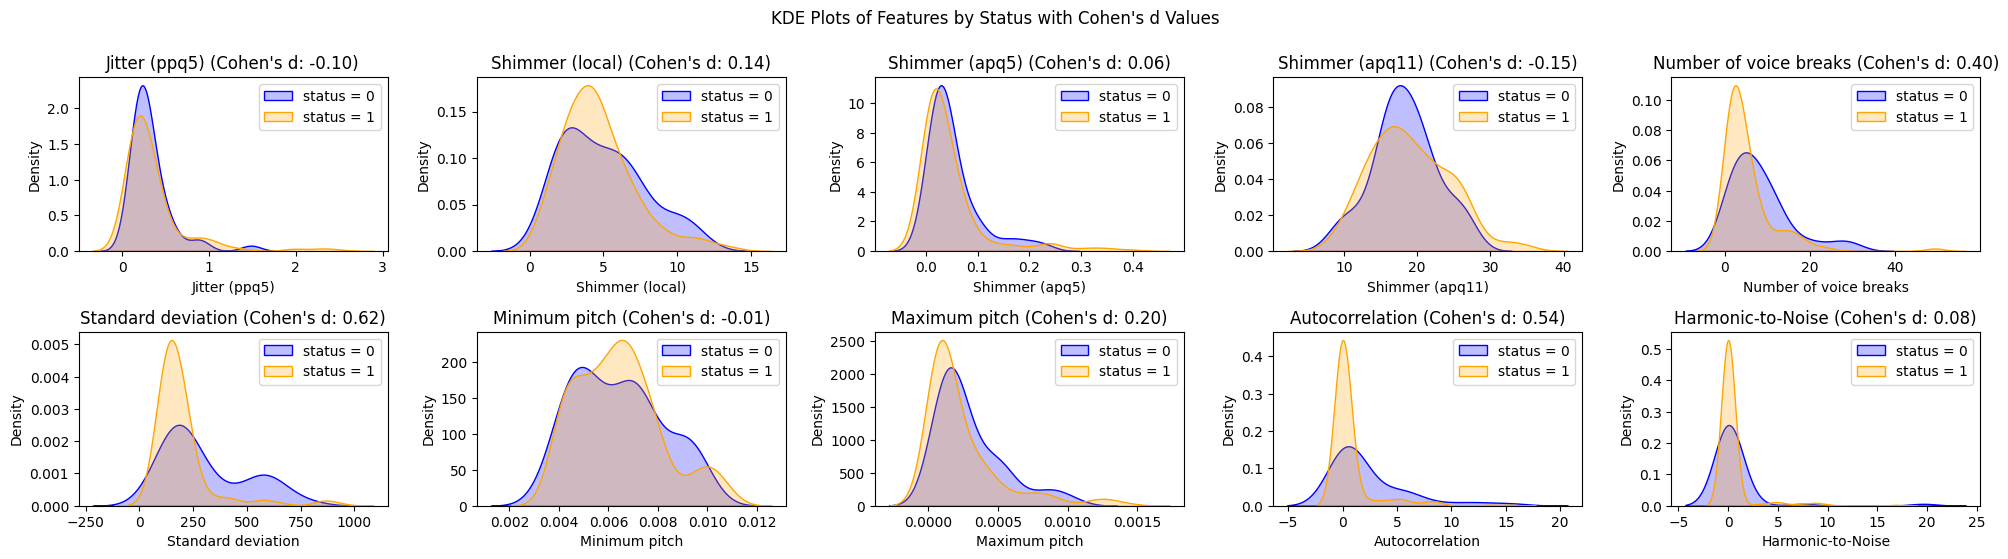

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with cluster labels and selected_columns as features
selected_columns =   [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ]

# Calculate Cohen's d for each feature
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

cohen_d_values = {feature: cohen_d(df[df['status'] == 0][feature], df[df['status'] == 1][feature]) for feature in selected_columns}

# Print Cohen's d values
print("Cohen's d values for each feature:")
for feature, d_value in cohen_d_values.items():
    print(f"{feature}: {d_value:.2f}")

# Visualize with KDE plots
plt.figure(figsize=(20, 15))
for i, feature in enumerate(selected_columns, 1):
    plt.subplot(6,5, i)
    sns.kdeplot(df[df['status'] == 0][feature], shade=True, label='status = 0', color='blue')
    sns.kdeplot(df[df['status'] == 1][feature], shade=True, label='status = 1', color='orange')
    plt.title(f"{feature} (Cohen's d: {cohen_d_values[feature]:.2f})")
    plt.xlabel(feature)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.suptitle('KDE Plots of Features by Status with Cohen\'s d Values', y=1.02)

plt.savefig("/content/drive/MyDrive/UCI EDA.png")
plt.show()

Cohen's d values for each feature:
Jitter (ppq5): -0.10
Shimmer (local): 0.14
Shimmer (apq5): 0.06
Shimmer (apq11): -0.15
Number of voice breaks: 0.40
Standard deviation: 0.62
Minimum pitch: -0.01
Maximum pitch: 0.20
Autocorrelation: 0.54
Harmonic-to-Noise: 0.08


<ipython-input-78-678b781878b5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-78-678b781878b5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-78-678b781878b5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
<ipython-input-78-678b781878b5>:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be 

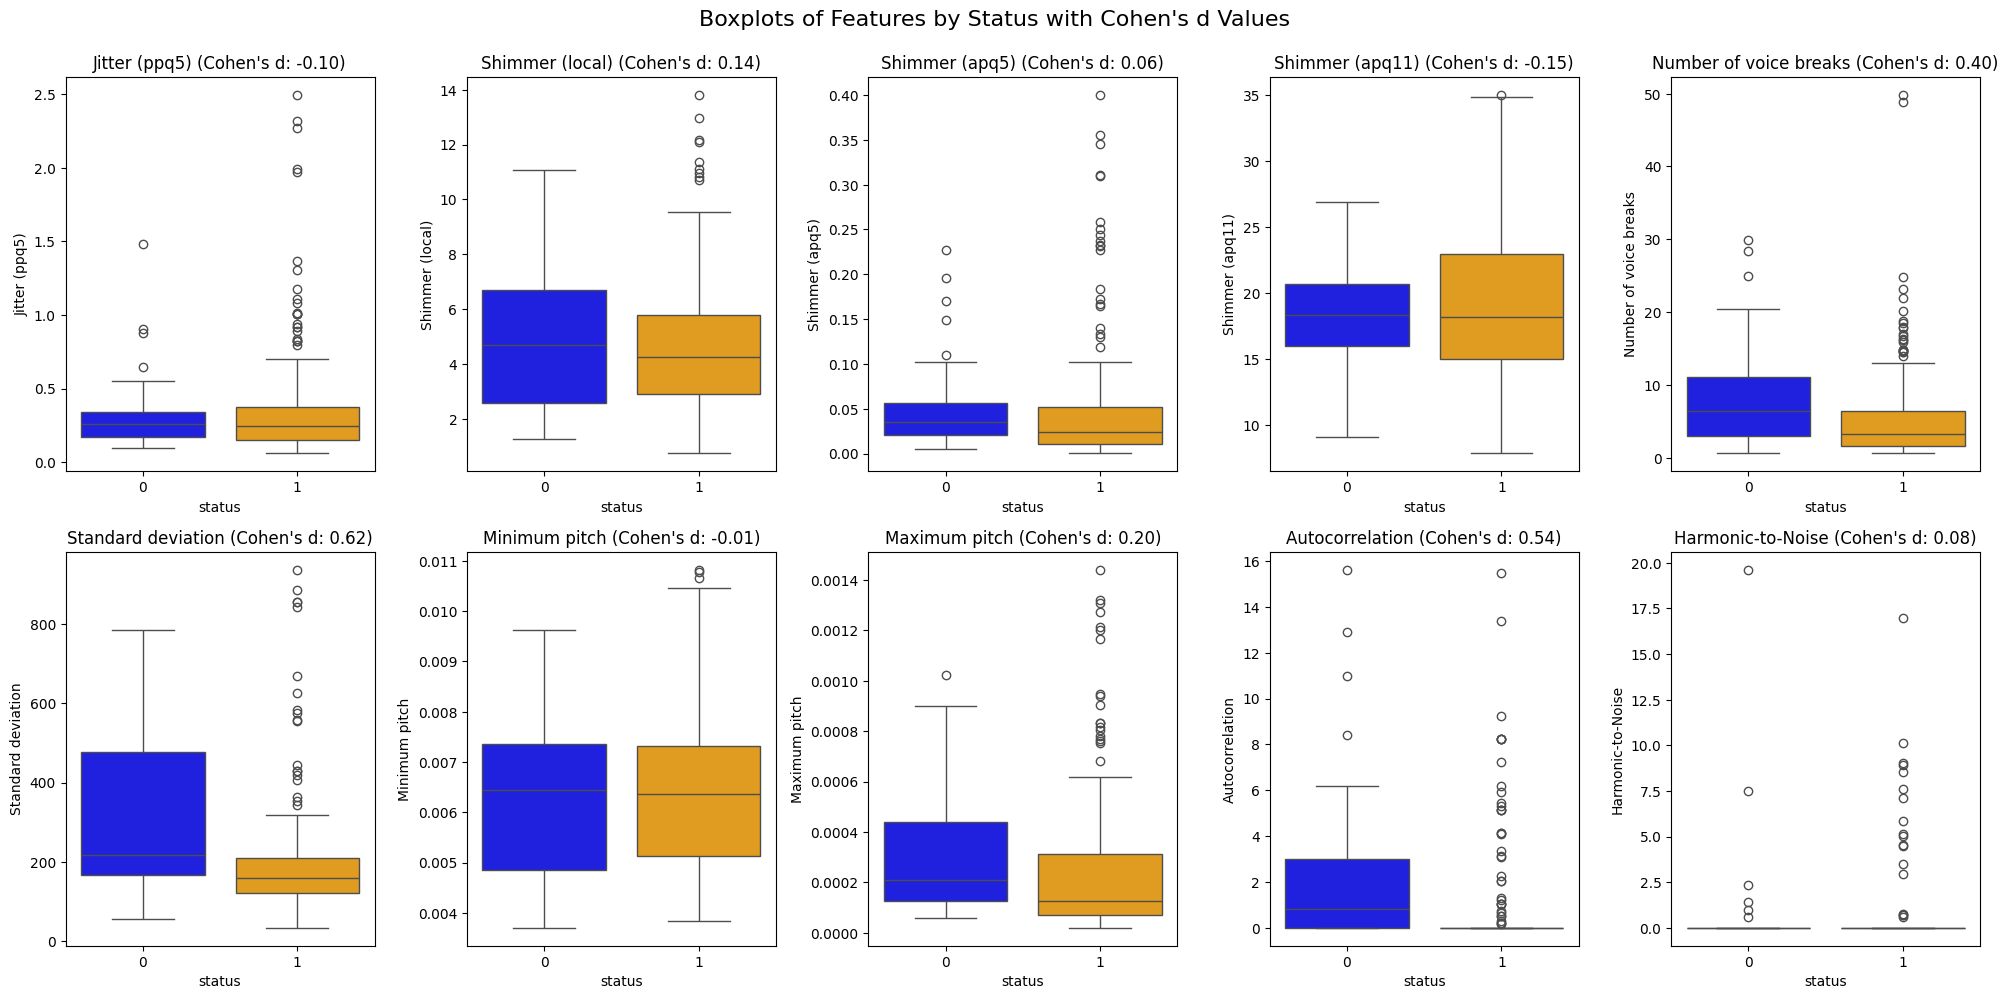

In [ ]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame with cluster labels and selected_columns as features
selected_columns =  [
        'Jitter (ppq5)','Shimmer (local)',
        'Shimmer (apq5)', 'Shimmer (apq11)',
        'Number of voice breaks',
        'Standard deviation',
        'Minimum pitch',
        'Maximum pitch', 'Autocorrelation', 'Harmonic-to-Noise'
    ]
# Calculate Cohen's d for each feature
def cohen_d(x, y):
    return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2)

cohen_d_values = {feature: cohen_d(df[df['status'] == 0][feature], df[df['status'] == 1][feature]) for feature in selected_columns}

# Print Cohen's d values
print("Cohen's d values for each feature:")
for feature, d_value in cohen_d_values.items():
    print(f"{feature}: {d_value:.2f}")

# Visualize with KDE plots and Boxplots
plt.figure(figsize=(20, 30))

for i, feature in enumerate(selected_columns, 1):
    # Boxplot
    plt.subplot(6, 5, i)
    sns.boxplot(x='status', y=feature, data=df, palette=['blue', 'orange'])
    plt.title(f"{feature} (Cohen's d: {cohen_d_values[feature]:.2f})")
    plt.xlabel('status')
    plt.ylabel(feature)

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.suptitle('Boxplots of Features by Status with Cohen\'s d Values', fontsize=16)

# Save the plot as a PNG file
plt.savefig("/content/drive/MyDrive/UCI EDA 2.png")
plt.show()

K-means Silhouette Score: 0.32448809028837455
Adjusted Rand Index for K-means: 0.11718656024095102
Normalized Mutual Information for K-means: 0.09433856773474983


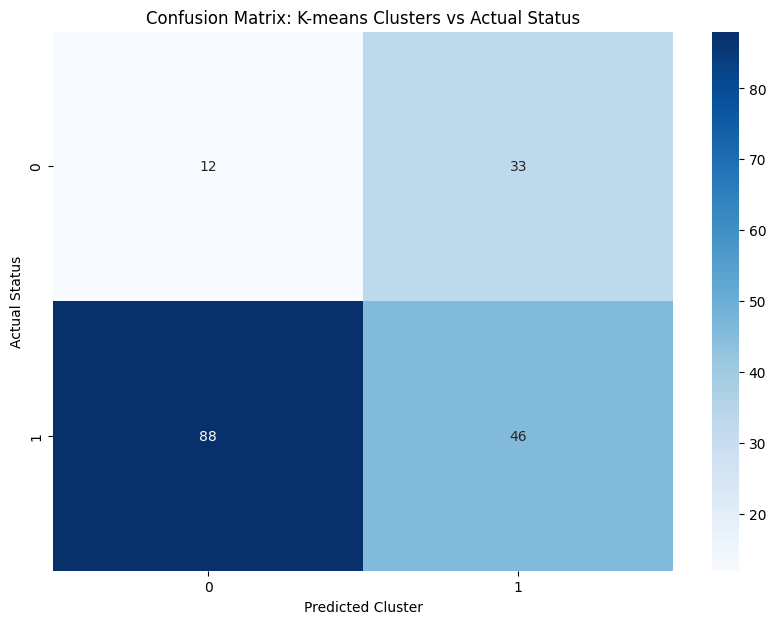

In [ ]:
from sklearn.metrics import silhouette_score, adjusted_rand_score, normalized_mutual_info_score, confusion_matrix

# Silhouette score for K-means
kmeans_silhouette = silhouette_score(features_scaled, kmeans_labels)
print(f'K-means Silhouette Score: {kmeans_silhouette}')

# Adjusted Rand Index
ari_kmeans = adjusted_rand_score(df['status'], df['kmeans_cluster'])
print(f'Adjusted Rand Index for K-means: {ari_kmeans}')

# Normalized Mutual Information
nmi_kmeans = normalized_mutual_info_score(df['status'], df['kmeans_cluster'])
print(f'Normalized Mutual Information for K-means: {nmi_kmeans}')

# Confusion matrix
conf_matrix = confusion_matrix(df['status'], df['kmeans_cluster'])

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Cluster')
plt.ylabel('Actual Status')
plt.title('Confusion Matrix: K-means Clusters vs Actual Status')
plt.show()